<a href="https://colab.research.google.com/github/matteo9910/StressDetectionBasedOnWearableSensorData/blob/main/TRANSFERLEARNING_CROSSTEST_CNN_AffectiveRoad_45SEC_75OL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import zipfile
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import seaborn as sns
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro
import math
from scipy.stats import mannwhitneyu
from scipy.signal import welch
import ipywidgets as widgets
from IPython.display import display
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.signal import resample
from scipy.signal import find_peaks
import scipy.signal

In [ ]:
zip_path = "/content/drive/MyDrive/AffectiveRoad Dataset/AffectiveROAD_Data_w1dqSB9.zip"
extract_to = "/content/drive/MyDrive/AffectiveRoad Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [ ]:
base_path = "/content/drive/MyDrive/AffectiveRoad Dataset/AffectiveROAD_Data/Database/E4"
print("Esiste?", os.path.exists(base_path))  # Deve stampare: True

Esiste? True


In [ ]:
base_path = "/content/drive/MyDrive/AffectiveRoad Dataset/AffectiveROAD_Data/Database/E4"

for root, dirs, files in os.walk(base_path):
    level = root.replace(base_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

E4/
    Annot_E4_Left.csv
    .DS_Store
    Annot_E4_Right.csv
    4-E4-Drv4/
        Left.zip
        Right.zip
        unzipped_Left/
            IBI.csv
            TEMP.csv
            EDA.csv
            ACC.csv
            BVP.csv
            info.txt
            HR.csv
            tags.csv
    5-E4-Drv5/
        Right.zip
        Left.zip
        unzipped_Left/
            ACC.csv
            EDA.csv
            TEMP.csv
            BVP.csv
            IBI.csv
            HR.csv
            info.txt
            tags.csv
    9-E4-Drv9/
        Right.zip
        Left.zip
        unzipped_Left/
            EDA.csv
            ACC.csv
            TEMP.csv
            BVP.csv
            IBI.csv
            HR.csv
            tags.csv
            info.txt
    1-E4-Drv1/
        Right.zip
        Left.zip
        unzipped_Left/
            TEMP.csv
            EDA.csv
            BVP.csv
            ACC.csv
            IBI.csv
            HR.csv
            tags.csv
            info.t

In [ ]:
def parse_numeric_value(x):
    """
    Pulisce una stringa con più punti nel numero, mantenendo solo il primo come separatore decimale.
    """
    try:
        if isinstance(x, str):
            x = x.strip().replace(' ', '')  # Rimuove spazi
            if x.count('.') > 1:
                parts = x.split('.')
                return float(parts[0] + '.' + ''.join(parts[1:]))
            return float(x)
        return float(x)
    except:
        return np.nan

In [ ]:
def load_affectiveroad_data(base_path, target_freq=64):
    """
    Carica ed effettua upsampling dei dati Empatica E4 per tutti i soggetti in AffectiveROAD Dataset.
    """
    signal_files = ['ACC.csv', 'BVP.csv', 'EDA.csv', 'TEMP.csv']
    all_data = []

    subject_folders = sorted([
        d for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d)) and d.endswith("-E4-Drv" + d.split("-")[0])
        or d.startswith(tuple([f"{i}-E4-Drv" for i in range(1, 14)]))
    ])

    for folder in subject_folders:
        subject_path = os.path.join(base_path, folder)
        zip_names = [f for f in os.listdir(subject_path) if f.startswith("Left") and f.endswith(".zip")]

        for zip_name in zip_names:
            with zipfile.ZipFile(os.path.join(subject_path, zip_name), 'r') as zip_ref:
                zip_ref.extractall(subject_path + "/unzipped_" + zip_name.split(".")[0])

        unzipped_folders = [os.path.join(subject_path, d) for d in os.listdir(subject_path) if d.startswith("unzipped_")]

        for unzip_dir in unzipped_folders:
            signals = {}

            for signal_file in signal_files:
                file_path = os.path.join(unzip_dir, signal_file)
                if not os.path.exists(file_path):
                    continue

                try:
                    raw_data = pd.read_csv(file_path, skiprows=2, header=None)
                    for col in raw_data.columns:
                        raw_data[col] = raw_data[col].map(parse_numeric_value)

                    # Frequenze originali
                    freq_map = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4}
                    orig_freq = freq_map[signal_file.split('.')[0]]
                    n_samples = int(len(raw_data) * target_freq / orig_freq)

                    resampled = resample(raw_data.values, n_samples, axis=0)

                    if signal_file == 'ACC.csv':
                        signals['acc1'] = resampled[:, 0]
                        signals['acc2'] = resampled[:, 1]
                        signals['acc3'] = resampled[:, 2]
                    else:
                        signals[signal_file.split('.')[0].lower()] = resampled.squeeze()
                except Exception as e:
                    print(f"Errore su {file_path}: {e}")
                    continue

            # Allinea lunghezza
            min_len = min(len(sig) for sig in signals.values())
            for k in signals:
                signals[k] = signals[k][:min_len]

            df = pd.DataFrame(signals)
            df["subject"] = folder.split("-")[-1]  # Es. 'Drv1'
            all_data.append(df)

    return pd.concat(all_data, ignore_index=True)

In [ ]:
base_path = "/content/drive/MyDrive/AffectiveRoad Dataset/AffectiveROAD_Data/Database/E4"
df = load_affectiveroad_data(base_path, target_freq=64)

In [ ]:
print("Shape of AffectiveRoadDataset:", df.shape)
df.head()

Shape of AffectiveRoadDataset: (5693652, 7)


,acc1,acc2,acc3,bvp,eda,temp,subject
0,7.000000,-44.000000,45.000000,-3.439623e-14,3.026075e-15,382.180000,Drv1
1,11.999693,-53.519621,44.413727,-1.656125e-14,-2.061213e-01,399.175096,Drv1
2,7.000000,-42.000000,46.000000,2.038345e-14,-3.672994e-01,413.836202,Drv1
3,-0.196511,-34.550733,47.149869,-3.567041e-14,-4.830911e-01,426.002278,Drv1
4,-4.000000,-40.000000,47.000000,-1.273737e-14,-5.540607e-01,435.565582,Drv1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5693652 entries, 0 to 5693651
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   acc1     float64
 1   acc2     float64
 2   acc3     float64
 3   bvp      float64
 4   eda      float64
 5   temp     float64
 6   subject  object 
dtypes: float64(6), object(1)
memory usage: 304.1+ MB


In [ ]:
df.describe()

,acc1,acc2,acc3,bvp,eda,temp
count,5.693652e+06,5.693652e+06,5.693652e+06,5.693652e+06,5.693652e+06,5.693652e+06
mean,-2.700631e+01,-1.037054e+01,3.556739e+01,-5.428502e-05,5.320919e+00,3.382515e+01
std,2.711127e+01,2.529767e+01,2.585755e+01,9.477823e+01,5.395179e+00,4.445436e+00
min,-2.023257e+02,-1.720794e+02,-1.692707e+02,-2.089750e+03,-2.969124e+00,-1.070650e+01
25%,-4.807159e+01,-3.000000e+01,2.100000e+01,-2.630000e+01,1.508182e+00,3.228942e+01
50%,-2.800000e+01,-9.090761e+00,4.392683e+01,2.130000e+00,3.923683e+00,3.365961e+01
75%,-1.200000e+01,5.844741e+00,5.591472e+01,3.016000e+01,6.932137e+00,3.545296e+01
max,2.024553e+02,1.745994e+02,1.668622e+02,2.087630e+03,2.802013e+01,4.494678e+02


In [ ]:
df['subject'].value_counts()

,count
subject,
Drv10,572928
Drv2,458688
Drv11,456384
Drv5,444768
Drv6,438912
Drv13,436864
Drv3,429056
Drv7,424832
Drv8,420992


In [ ]:
def load_subjective_metrics(base_path):
    """
    Carica i file SM_Drvx.csv contenenti le metriche soggettive,
    aggiungendo le colonne 'stress_ratio' e 'Subject'.
    """
    all_data = []

    for i in range(1, 14):  # Drv1 a Drv13
        file_name = f"SM_Drv{i}.csv"
        file_path = os.path.join(base_path, file_name)

        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            if df.shape[1] == 1:
                df.columns = ['stress_ratio']
            else:
                print(f"[ATTENZIONE] Struttura inattesa in {file_name}: {df.columns.tolist()}")
                continue

            df['Subject'] = f'Drv{i}'
            all_data.append(df)
        else:
            print(f"[ATTENZIONE] File non trovato: {file_path}")

    return pd.concat(all_data, ignore_index=True)

In [ ]:
base_path = "/content/drive/MyDrive/AffectiveRoad Dataset/AffectiveROAD_Data/Database/Subj_metric"
subjective_metrics = load_subjective_metrics(base_path)

In [ ]:
print("Shape of Subjective Metric:", subjective_metrics.shape)
subjective_metrics.head()

Shape of Subjective Metric: (194568, 2)


,stress_ratio,Subject
0,0.0,Drv1
1,0.0,Drv1
2,0.0,Drv1
3,0.0,Drv1
4,0.0,Drv1


In [ ]:
def label_protocol_phases(subjective_metrics, annotation_csv_path):
    import pandas as pd

    # Carica le annotazioni
    annotation_df = pd.read_csv(annotation_csv_path)
    subjective_metrics['Protocol'] = None  # Reset colonna

    for _, row in annotation_df.iterrows():
        subject_id = row['Drive_id']
        subj_mask = subjective_metrics['Subject'] == subject_id
        subj_data = subjective_metrics[subj_mask].copy()

        # Crea lista delle fasi del protocollo
        phases = [
            ('Z', row['Z_Start'], row['Z_End']),
            ('City1', row['City1_Start'], row['City1_End']),
            ('Hwy', row['Hwy_Start'], row['Hwy_End']),
            ('City2', row['City2_Start'], row['City2_End']),
            ('City2_2', row['City2_Start.1'], row['City2_End.1']),
            ('Hwy_2', row['Hwy_Start.1'], row['Hwy_End.1']),
        ]

        # Filtra solo fasi valide (non NaN)
        valid_phases = [(name, int(start), int(end)) for name, start, end in phases if pd.notna(start) and pd.notna(end)]
        valid_phases.sort(key=lambda x: x[1])  # Ordina per indice di inizio

        # Etichettatura delle fasi principali
        for name, start, end in valid_phases:
            indices = subj_data.iloc[start:end+1].index
            subjective_metrics.loc[indices, 'Protocol'] = name

        # Etichettatura delle fasi di transizione
        for i in range(len(valid_phases) - 1):
            prev_end = valid_phases[i][2]
            next_start = valid_phases[i + 1][1]

            if next_start > prev_end + 1:
                trans_label = f'Transition{i + 1}'
                indices = subj_data.iloc[prev_end + 1:next_start].index
                subjective_metrics.loc[indices, 'Protocol'] = trans_label

    return subjective_metrics

In [ ]:
annotation_path = "/content/drive/MyDrive/AffectiveRoad Dataset/AffectiveROAD_Data/Database/Subj_metric/Annot_Subjective_metric.csv"

subjective_metrics = label_protocol_phases(subjective_metrics, annotation_path)

In [ ]:
# Raggruppa per soggetto e tratto
grouped = subjective_metrics.reset_index().groupby(['Subject', 'Protocol'])['index']

# Calcola min e max per ogni blocco
phase_ranges = grouped.agg(Start_Index='min', End_Index='max', N_Samples='count')

# Mostra il risultato
pd.set_option('display.max_rows', 100)  # Aumenta se hai molti soggetti
display(phase_ranges)

Start_Index  End_Index  N_Samples
Subject Protocol                                      
Drv1    City1                624       1736       1113
        City2               4056       6628       2573
        City2_2             6936       8892       1957
        Hwy                 2416       3536       1121
        Hwy_2               9004      10232       1229
...                          ...        ...        ...
Drv9    Transition2       104718     105196        479
        Transition3       106262     106632        371
        Transition4       108478     108876        399
        Transition5       110858     110964        107
        Z                 103130     103577        448

[143 rows x 3 columns]

In [ ]:
def plot_stress_by_protocol_line(subjective_metrics, subjects=None):
    import matplotlib.pyplot as plt

    # Se non specificato, usa tutti i soggetti
    if subjects is None:
        subjects = subjective_metrics['Subject'].unique()

    # Ordine dei protocolli per consistenza visiva
    protocol_order = ['Z', 'Transition1', 'City1', 'Transition2', 'Hwy', 'Transition3',
                      'City2', 'Transition4', 'City2_2', 'Transition5', 'Hwy_2']

    for subj in subjects:
        df_subj = subjective_metrics[subjective_metrics['Subject'] == subj].copy()
        df_subj = df_subj.reset_index()

        plt.figure(figsize=(16, 4))
        ax = plt.gca()

        for prot in df_subj['Protocol'].dropna().unique():
            prot_df = df_subj[df_subj['Protocol'] == prot]
            if not prot_df.empty:
                ax.plot(prot_df['index'], prot_df['stress_ratio'], label=prot)
                ax.fill_between(prot_df['index'], prot_df['stress_ratio'], alpha=0.3)

        ax.set_title(f'Stress Ratio over Time – Subject {subj}')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Stress Ratio')
        ax.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

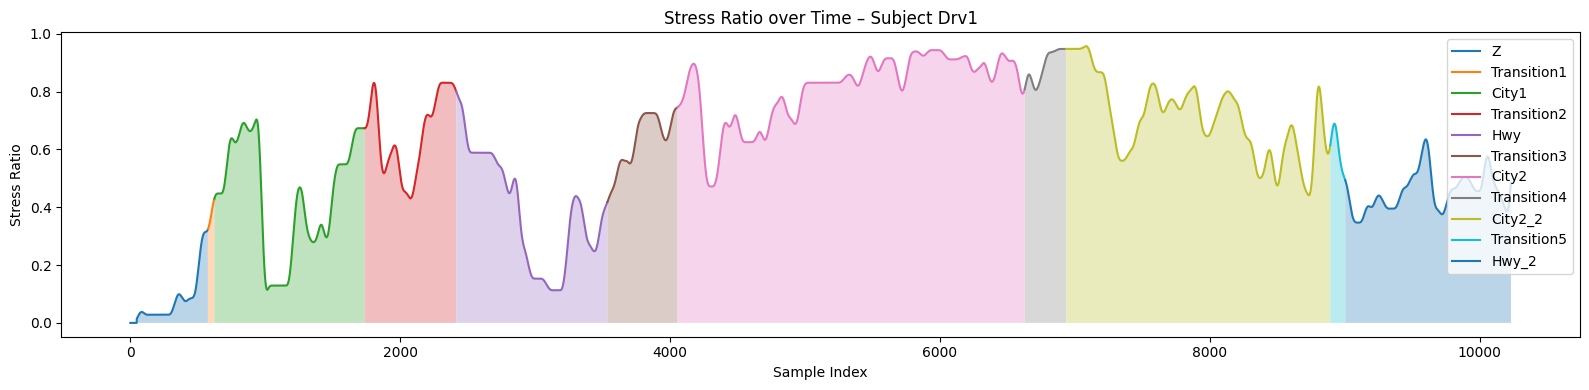

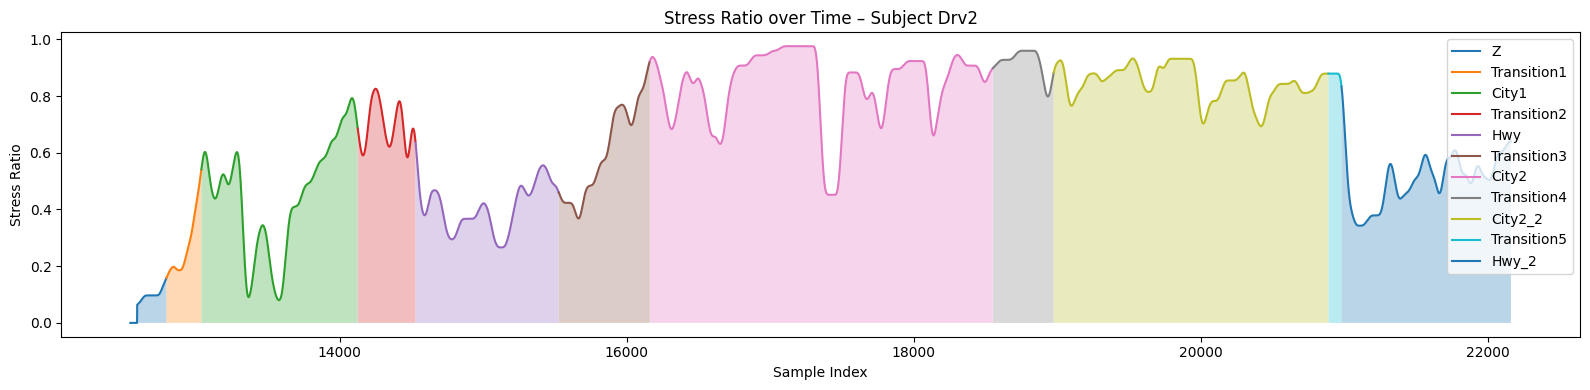

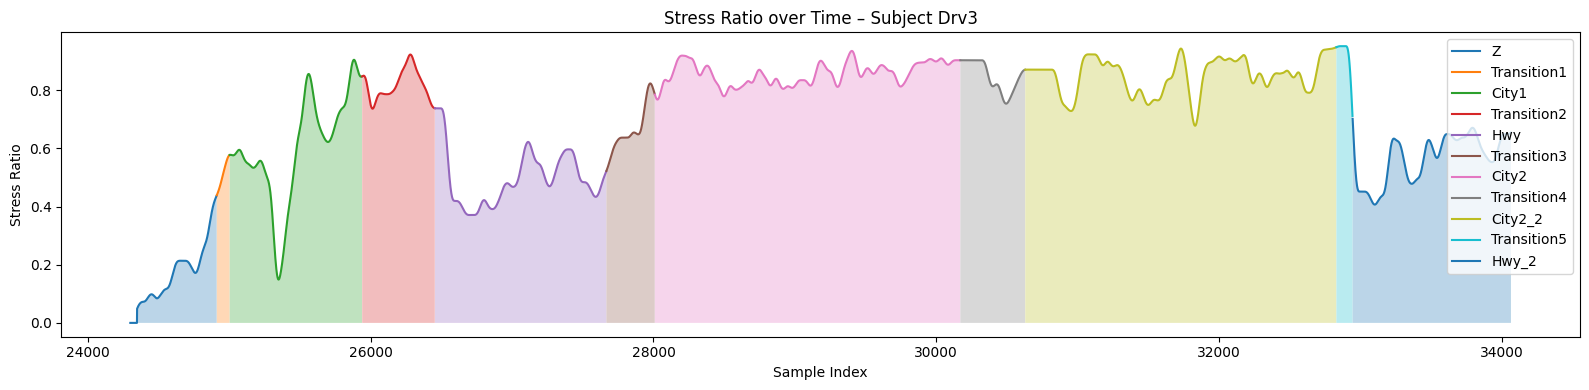

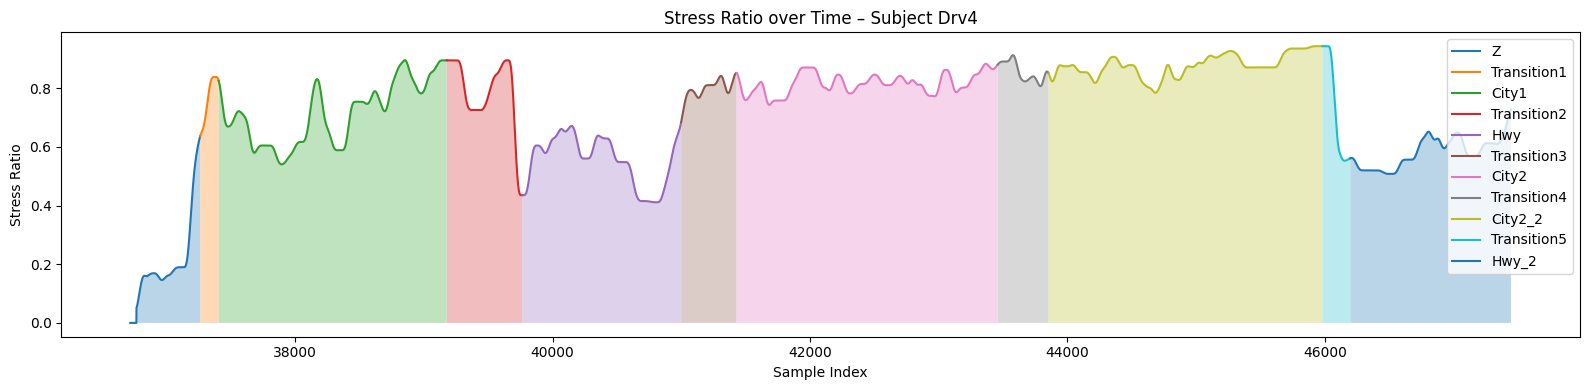

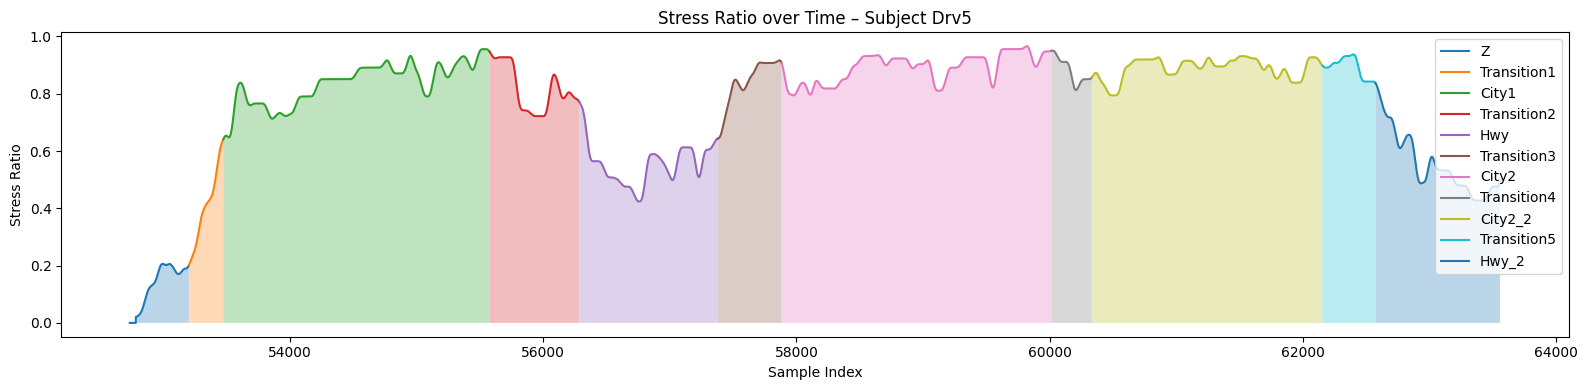

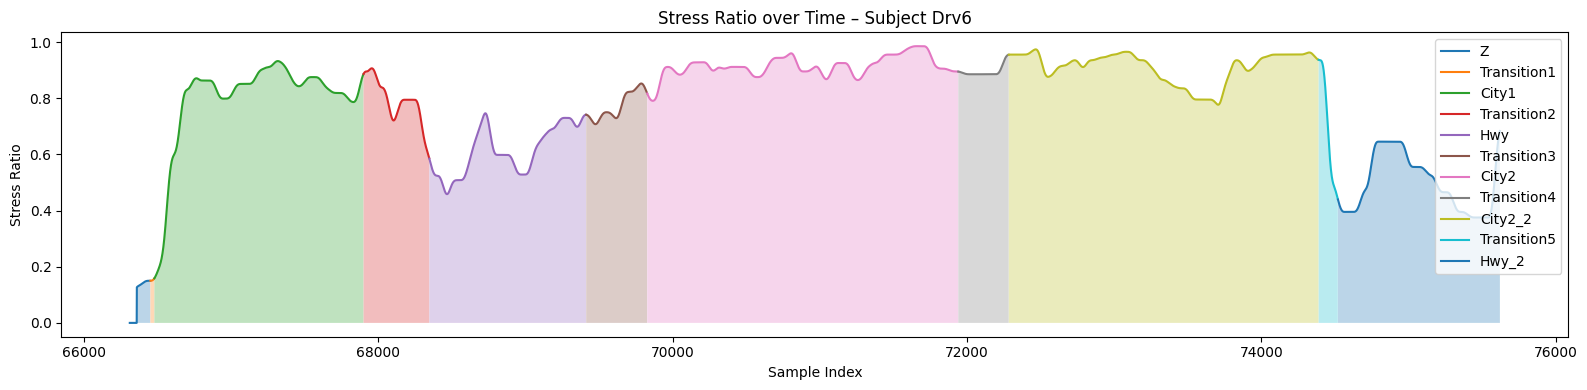

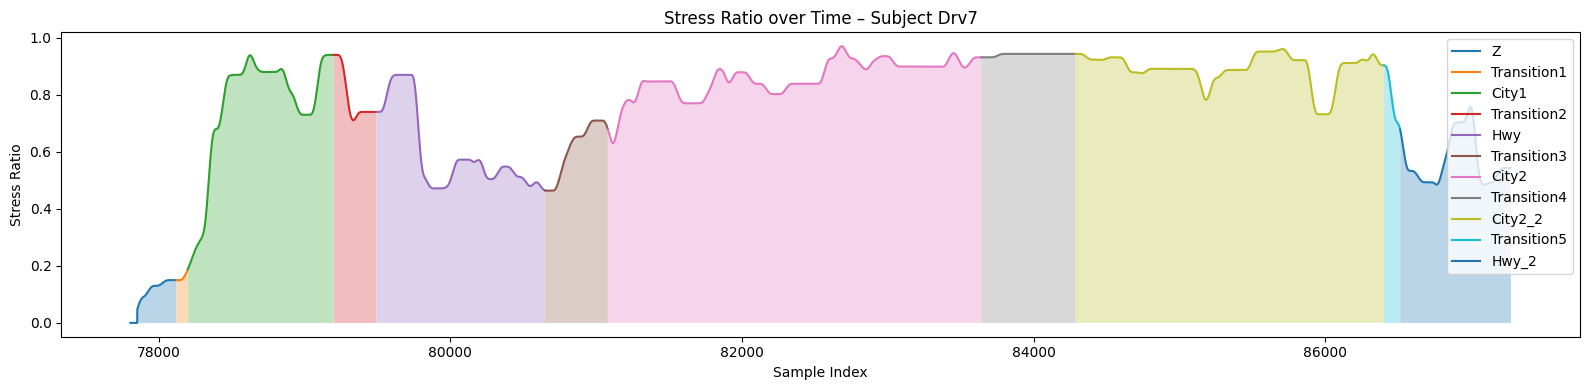

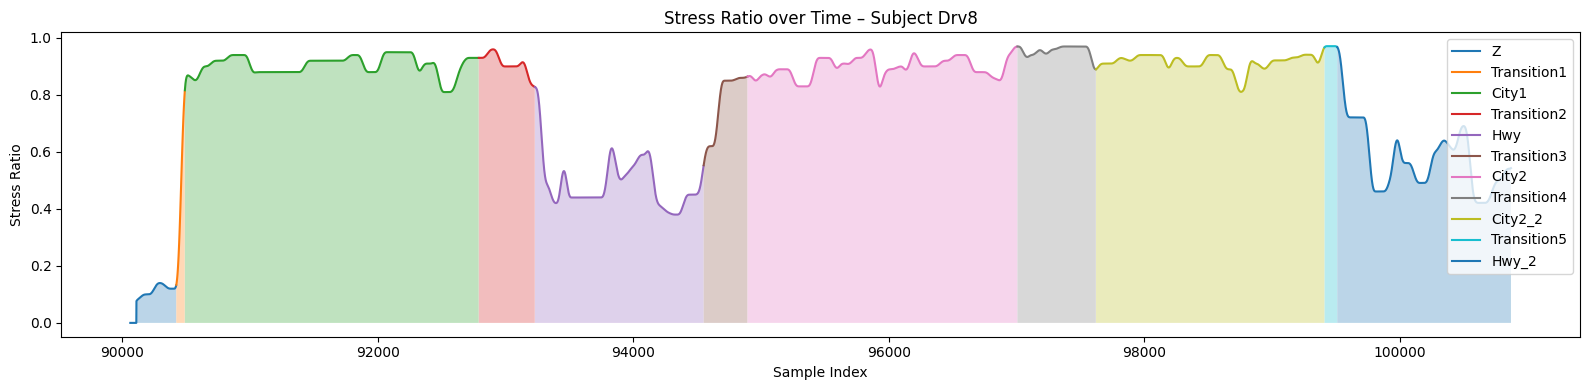

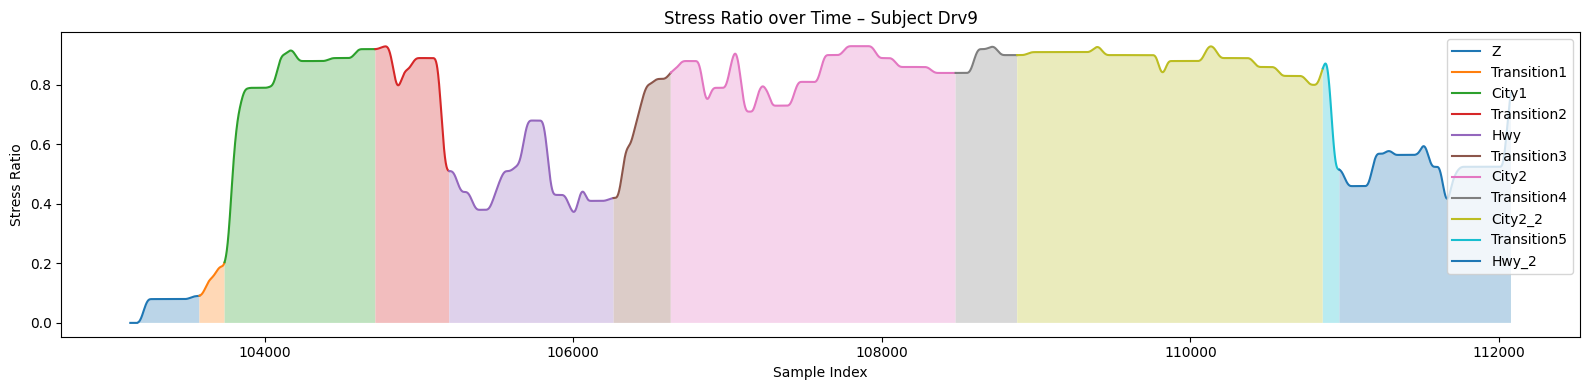

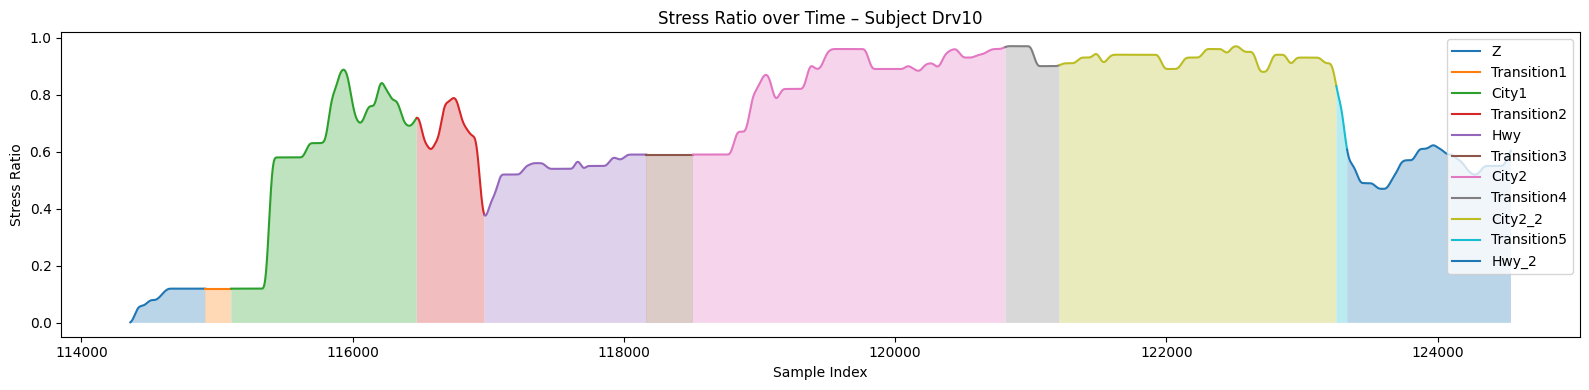

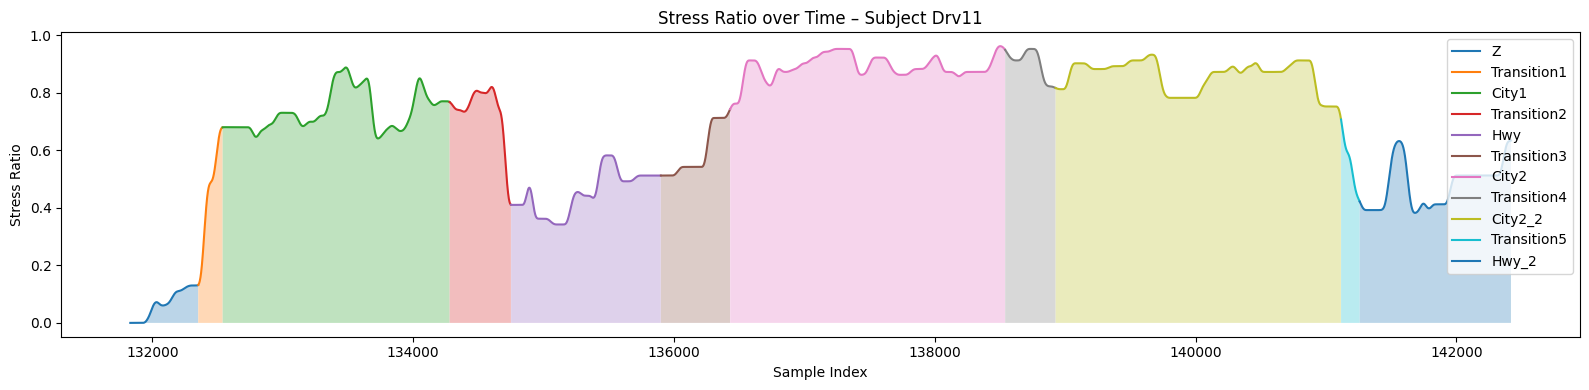

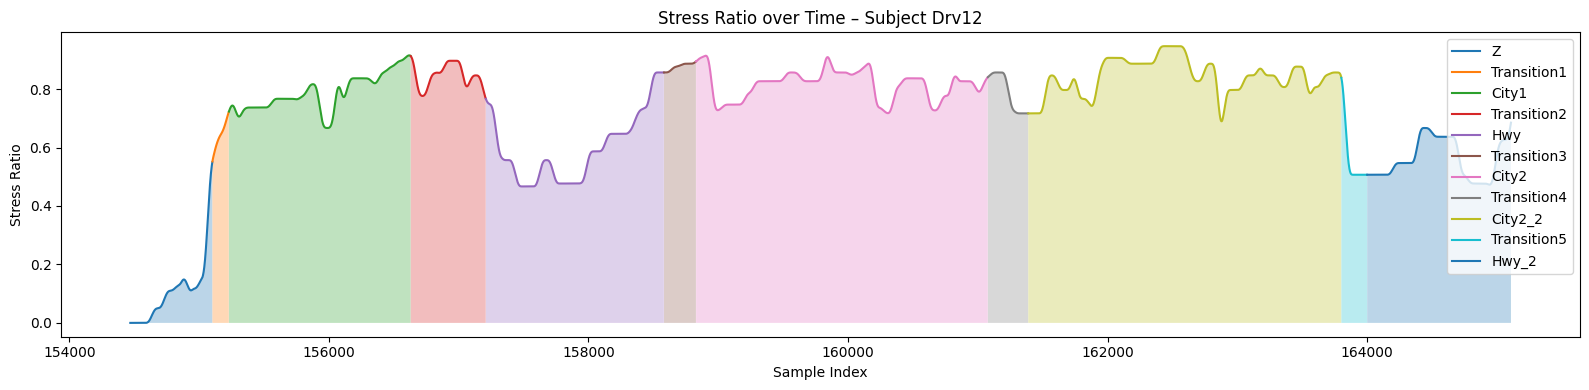

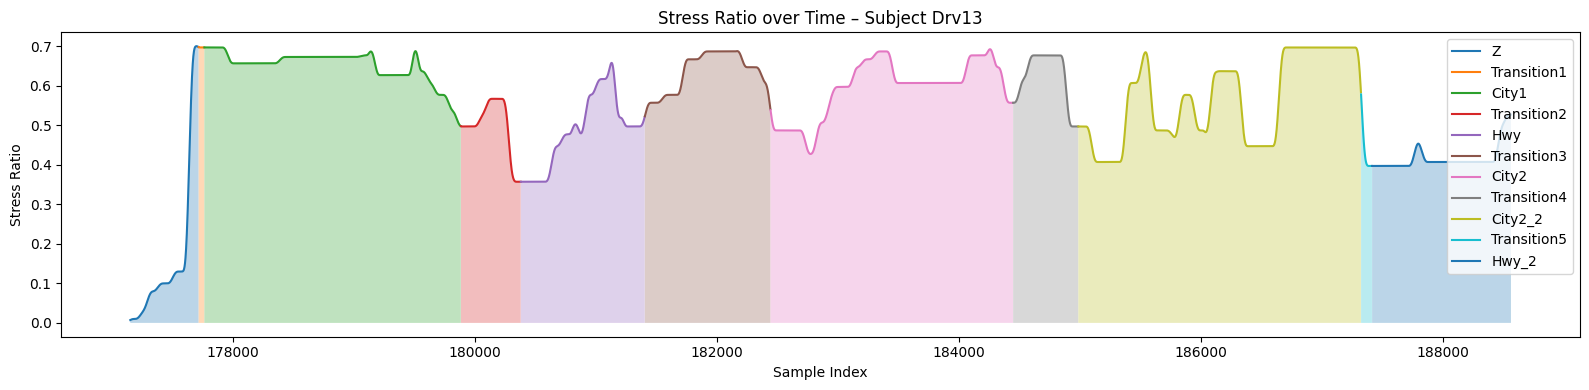

In [ ]:
plot_stress_by_protocol_line(subjective_metrics)

In [ ]:
subjective_metrics.groupby('Subject').size()

,0
Subject,
Drv1,12542
Drv10,12475
Drv11,22274
Drv12,22622
Drv13,22965
Drv2,11756
Drv3,12420
Drv4,16013
Drv5,13581


In [ ]:
def upsample_subjective_metrics_resample(subjective_metrics, df, value_col="stress_ratio"):
    """
    Esegue upsampling tramite duplicazione dei valori (no interpolazione).
    Per ogni soggetto, ripete i valori di `value_col` fino a raggiungere la stessa lunghezza
    dei segnali fisiologici in df.
    """
    upsampled_list = []

    subjects = df['subject'].unique()

    for subject in subjects:
        df_sub = df[df['subject'] == subject]
        sm_sub = subjective_metrics[subjective_metrics['Subject'] == subject]

        len_target = len(df_sub)
        len_source = len(sm_sub)

        if len_target == 0 or len_source == 0:
            print(f"[ATTENZIONE] Soggetto {subject} mancante in uno dei dataset.")
            continue

        # Calcola il numero di ripetizioni necessario per ogni valore
        repeated = np.repeat(sm_sub[value_col].values, np.ceil(len_target / len_source).astype(int))
        repeated = repeated[:len_target]  # Tronca all'esatto numero di sample target

        upsampled_df = pd.DataFrame({
            'subject': [subject] * len_target,
            'upsampled_stress_ratio': repeated
        })

        upsampled_list.append(upsampled_df)

    return pd.concat(upsampled_list, ignore_index=True)

In [ ]:
upsampled_labels = upsample_subjective_metrics_resample(subjective_metrics, df)

In [ ]:
upsampled_labels.groupby('subject').size()

,0
subject,
Drv1,365440
Drv10,572928
Drv11,456384
Drv12,415860
Drv13,436864
Drv2,458688
Drv3,429056
Drv4,412928
Drv5,444768


In [ ]:
df = pd.concat([df.reset_index(drop=True), upsampled_labels["upsampled_stress_ratio"]], axis=1)
df.rename(columns={"upsampled_stress_ratio": "stress_ratio"}, inplace=True)

In [ ]:
df["stress_ratio"] = (df["stress_ratio"] > 0.75).astype(int)
df.rename(columns={"stress_ratio": "label"}, inplace=True)

In [ ]:
df.head()

,acc1,acc2,acc3,bvp,eda,temp,subject,label
0,7.000000,-44.000000,45.000000,-3.439623e-14,3.026075e-15,382.180000,Drv1,0
1,11.999693,-53.519621,44.413727,-1.656125e-14,-2.061213e-01,399.175096,Drv1,0
2,7.000000,-42.000000,46.000000,2.038345e-14,-3.672994e-01,413.836202,Drv1,0
3,-0.196511,-34.550733,47.149869,-3.567041e-14,-4.830911e-01,426.002278,Drv1,0
4,-4.000000,-40.000000,47.000000,-1.273737e-14,-5.540607e-01,435.565582,Drv1,0


In [ ]:
df['acc_mag'] = np.sqrt(df['acc1']**2+df['acc2']**2+df['acc3']**2)
df = df.drop(columns = ['acc1', 'acc2', 'acc3'], axis = 1)

In [ ]:
df.head()

,bvp,eda,temp,subject,label,acc_mag
0,-3.439623e-14,3.026075e-15,382.180000,Drv1,0,63.324561
1,-1.656125e-14,-2.061213e-01,399.175096,Drv1,0,70.575644
2,2.038345e-14,-3.672994e-01,413.836202,Drv1,0,62.681736
3,-3.567041e-14,-4.830911e-01,426.002278,Drv1,0,58.454272
4,-1.273737e-14,-5.540607e-01,435.565582,Drv1,0,61.846584


In [ ]:
def replace_outliers_with_median(df, columns):
    df_cleaned = df.copy()

    for col in columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median_val = df_cleaned[col].median()

        outlier_mask = (df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)
        df_cleaned.loc[outlier_mask, col] = median_val

    return df_cleaned

In [ ]:
columns_to_clean = ['bvp', 'eda', 'temp', 'acc_mag']
df = replace_outliers_with_median(df, columns_to_clean)

In [ ]:
df.describe()

,bvp,eda,temp,label,acc_mag
count,5.693652e+06,5.693652e+06,5.693652e+06,5.693652e+06,5.693652e+06
mean,2.273010e+00,4.103463e+00,3.377933e+01,4.930305e-01,6.357901e+01
std,3.981300e+01,3.114999e+00,1.895057e+00,4.999515e-01,2.075574e+00
min,-1.109800e+02,-2.969124e+00,2.754553e+01,0.000000e+00,5.739622e+01
25%,-1.472000e+01,1.508182e+00,3.228969e+01,0.000000e+00,6.258594e+01
50%,2.130000e+00,3.923683e+00,3.365961e+01,0.000000e+00,6.363175e+01
75%,2.120000e+01,6.166415e+00,3.545217e+01,1.000000e+00,6.451972e+01
max,1.148500e+02,1.506790e+01,4.019322e+01,1.000000e+00,6.975897e+01


In [ ]:
freq_assolute = df["label"].value_counts()
freq_relative = df["label"].value_counts(normalize=True)

frequency_table = pd.DataFrame({
    'Frequenza Assoluta': freq_assolute,
    'Frequenza Relativa (%)': freq_relative.round(2)*100
})

frequency_table

,Frequenza Assoluta,Frequenza Relativa (%)
label,,
0,2886508,51.0
1,2807144,49.0


In [ ]:
# Raggruppa per soggetto e label
grouped = df.groupby(['subject', 'label']).size().unstack(fill_value=0)

# Calcola totali e percentuali
grouped['Totale'] = grouped[0] + grouped[1]
grouped['% Stress (1)'] = (grouped[1] / grouped['Totale'] * 100).round(2)
grouped['% Baseline (0)'] = (grouped[0] / grouped['Totale'] * 100).round(2)

# Rinomina colonne per chiarezza
grouped.rename(columns={0: 'Baseline (0)', 1: 'Stress (1)'}, inplace=True)

grouped = grouped[['Baseline (0)', 'Stress (1)', 'Totale', '% Baseline (0)', '% Stress (1)']]
grouped

label,Baseline (0),Stress (1),Totale,% Baseline (0),% Stress (1)
subject,,,,,
Drv1,232360,133080,365440,63.58,36.42
Drv10,300884,272044,572928,52.52,47.48
Drv11,315075,141309,456384,69.04,30.96
Drv12,269085,146775,415860,64.71,35.29
Drv13,436864,0,436864,100.00,0.00
Drv2,235568,223120,458688,51.36,48.64
Drv3,191686,237370,429056,44.68,55.32
Drv4,219514,193414,412928,53.16,46.84
Drv5,132060,312708,444768,29.69,70.31


In [ ]:
df.isna().sum()

,0
bvp,0
eda,0
temp,0
subject,0
label,0
acc_mag,0


In [ ]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 16.0 MB/s eta 0:00:00


In [ ]:
import neurokit2 as nk

In [ ]:
ppg_raw = df["bvp"].values

fs = 64

ppg_signals, ppg_info = nk.ppg_process(ppg_raw, sampling_rate=fs)

ppg_clean = ppg_signals["PPG_Clean"]

df['bvp_clean'] = ppg_clean

In [ ]:
eda_raw = df["eda"].values

fs = 64

eda_signals, eda_info = nk.eda_process(eda_raw, sampling_rate=fs)

eda_clean = eda_signals["EDA_Clean"]

df['eda_clean'] = eda_clean

In [ ]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [ ]:
def acc_denoise(acc_signal, fs):

    b_high, a_high = butter_highpass(0.5, fs)
    acc_signal = filtfilt(b_high, a_high, acc_signal)

    b_low, a_low = butter_lowpass(20.0, fs)
    acc_signal = filtfilt(b_low, a_low, acc_signal)

    return acc_signal

In [ ]:
fs = 64
df['acc_clean'] = acc_denoise(df['acc_mag'].values, fs)

In [ ]:
def temp_denoise(temp_signal, fs):
  b_low, a_low = butter_lowpass(0.5, fs)
  temp_signal = filtfilt(b_low, a_low, temp_signal)
  return temp_signal

In [ ]:
fs = 64
df['temp_clean'] = temp_denoise(df['temp'].values, fs)

In [ ]:
fs = 64
win_sec = 45
overlap = 0.75
win_size = fs * win_sec
step_size = win_size // 2

In [ ]:
def create_windowed_array_per_signal(df, signal_col, fs=64, win_sec=45, overlap=0.75, threshold=0.85):
    """
    Versione migliorata con soglia più alta e bilanciamento per soggetto
    """
    win_size = int(fs * win_sec)
    step_size = int(win_size * (1 - overlap))

    X = []
    y = []
    groups = []

    # NUOVO: Statistiche per bilanciamento
    subject_stats = {}

    for subject_id in df['subject'].unique():
        df_subj = df[df['subject'] == subject_id].reset_index(drop=True)
        signal = df_subj[signal_col].values.astype(np.float32)
        labels = df_subj['label'].values.astype(int)

        # NUOVO: Raccogli finestre per classe
        subject_windows_0 = []
        subject_windows_1 = []

        for start in range(0, len(signal) - win_size + 1, step_size):
            end = start + win_size
            window = signal[start:end]
            window_labels = labels[start:end]

            # Conta le occorrenze di ciascuna label nella finestra
            counts = np.bincount(window_labels, minlength=2)
            total = np.sum(counts)
            dominant_label = np.argmax(counts)
            dominant_ratio = counts[dominant_label] / total

            # MODIFICATO: Soglia più alta per finestre più pure
            if dominant_ratio >= threshold:
                if dominant_label == 0:
                    subject_windows_0.append((window, dominant_label, subject_id))
                else:
                    subject_windows_1.append((window, dominant_label, subject_id))

        # NUOVO: Bilanciamento per soggetto
        n_class_0 = len(subject_windows_0)
        n_class_1 = len(subject_windows_1)

        if n_class_0 > 0 and n_class_1 > 0:
            # Prendi il minimo tra le due classi per bilanciare
            min_samples = min(n_class_0, n_class_1)

            # Limita a massimo 100 campioni per classe per soggetto
            min_samples = min(min_samples, 100)

            # Campiona casualmente
            if n_class_0 >= min_samples:
                selected_0 = np.random.choice(len(subject_windows_0), min_samples, replace=False)
            else:
                selected_0 = range(len(subject_windows_0))

            if n_class_1 >= min_samples:
                selected_1 = np.random.choice(len(subject_windows_1), min_samples, replace=False)
            else:
                selected_1 = range(len(subject_windows_1))

            # Aggiungi finestre selezionate
            for idx in selected_0:
                window, label, subject = subject_windows_0[idx]
                X.append(window)
                y.append(label)
                groups.append(subject)

            for idx in selected_1:
                window, label, subject = subject_windows_1[idx]
                X.append(window)
                y.append(label)
                groups.append(subject)

            subject_stats[subject_id] = {
                'classe_0': len(selected_0),
                'classe_1': len(selected_1),
                'totale_0_disponibili': n_class_0,
                'totale_1_disponibili': n_class_1
            }
        else:
            print(f"[SKIP] Soggetto {subject_id} - Classe 0: {n_class_0}, Classe 1: {n_class_1}")

    # NUOVO: Mostra statistiche bilanciamento
    print("\n=== STATISTICHE BILANCIAMENTO ===")
    for subject, stats in subject_stats.items():
        print(f"{subject}: 0={stats['classe_0']}/{stats['totale_0_disponibili']}, "
              f"1={stats['classe_1']}/{stats['totale_1_disponibili']}")

    X = np.array(X)[..., np.newaxis]  # aggiungi dimensione canale per CNN
    y = np.array(y).astype(int)
    groups = np.array(groups)

    return X, y, groups

In [ ]:
 segnali = ['bvp_clean', 'eda_clean', 'acc_clean', 'temp_clean']

In [ ]:
X_dict = {}
for segnale in segnali:
    print(f"Processing {segnale}...")
    X, y_raw, groups = create_windowed_array_per_signal(
        df, signal_col=segnale, fs=fs, win_sec=win_sec, overlap=overlap, threshold=0.85  # Soglia più alta
    )
    if segnale == segnali[0]:
        y = y_raw
        group_labels = groups
    X_dict[segnale] = X

print(f"\nDataset finale: {len(y)} finestre")
print(f"Distribuzione classi: {np.unique(y, return_counts=True)}")

Processing bvp_clean...
[SKIP] Soggetto Drv13 - Classe 0: 603, Classe 1: 0

=== STATISTICHE BILANCIAMENTO ===
Drv1: 0=100/289, 1=100/151
Drv10: 0=100/400, 1=100/364
Drv11: 0=100/420, 1=100/183
Drv12: 0=100/341, 1=100/176
Drv2: 0=100/287, 1=100/271
Drv3: 0=100/241, 1=100/307
Drv4: 0=100/281, 1=100/242
Drv5: 0=100/165, 1=100/421
Drv6: 0=100/173, 1=100/413
Drv7: 0=100/190, 1=100/358
Drv8: 0=100/147, 1=100/416
Drv9: 0=100/189, 1=100/357
Processing eda_clean...
[SKIP] Soggetto Drv13 - Classe 0: 603, Classe 1: 0

=== STATISTICHE BILANCIAMENTO ===
Drv1: 0=100/289, 1=100/151
Drv10: 0=100/400, 1=100/364
Drv11: 0=100/420, 1=100/183
Drv12: 0=100/341, 1=100/176
Drv2: 0=100/287, 1=100/271
Drv3: 0=100/241, 1=100/307
Drv4: 0=100/281, 1=100/242
Drv5: 0=100/165, 1=100/421
Drv6: 0=100/173, 1=100/413
Drv7: 0=100/190, 1=100/358
Drv8: 0=100/147, 1=100/416
Drv9: 0=100/189, 1=100/357
Processing acc_clean...
[SKIP] Soggetto Drv13 - Classe 0: 603, Classe 1: 0

=== STATISTICHE BILANCIAMENTO ===
Drv1: 0=100/289,

In [ ]:
for segnale in segnali:
  print(f"Tipo: {type(X_dict[segnale])} Dimensione {segnale}: {X_dict[segnale].shape}")

Tipo: <class 'numpy.ndarray'> Dimensione bvp_clean: (2400, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione eda_clean: (2400, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione acc_clean: (2400, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione temp_clean: (2400, 2880, 1)


In [ ]:
print(f"Tipo: {type(y)} Dimensione y: {y.shape}")

Tipo: <class 'numpy.ndarray'> Dimensione y: (2400,)


In [ ]:
# Crea un DataFrame per l'analisi
df_windowed = pd.DataFrame({
    'subject': group_labels,  # questi sono i gruppi/soggetti per ogni finestra
    'label': y               # queste sono le label per ogni finestra
})

print(f"Dataset windowed: {len(df_windowed)} finestre totali")
print(f"Distribuzione globale: {np.unique(y, return_counts=True)}")

Dataset windowed: 2400 finestre totali
Distribuzione globale: (array([0, 1]), array([1200, 1200]))


In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([1200, 1200]))

In [ ]:
for seg in segnali:
    print(f"{seg}: {X_dict[seg].dtype}")

bvp_clean: float32
eda_clean: float32
acc_clean: float32
temp_clean: float32


WESAD --> AFFECTIVE ROAD

CROSS TEST WESAD CNN

=== MODELLO CARICATO ===
F1-Score originale: 0.9910
Soggetto migliore: S8

CROSS TEST: WESAD MODEL → AFFECTIVE ROAD DATASET
Inizio valutazione cross-test...
  Fold  1 - Drv1: F1=0.000 Acc=0.500
  Fold  2 - Drv10: F1=0.000 Acc=0.355
  Fold  3 - Drv11: F1=0.000 Acc=0.485
  Fold  4 - Drv12: F1=0.000 Acc=0.500
  Fold  5 - Drv2: F1=0.071 Acc=0.475
  Fold  6 - Drv3: F1=0.667 Acc=0.500
  Fold  7 - Drv4: F1=0.667 Acc=0.500
  Fold  8 - Drv5: F1=0.667 Acc=0.500
  Fold  9 - Drv6: F1=0.057 Acc=0.500
  Fold 10 - Drv7: F1=0.673 Acc=0.520
  Fold 11 - Drv8: F1=0.000 Acc=0.500
  Fold 12 - Drv9: F1=0.410 Acc=0.265

--------------------------------------------------
RISULTATI CROSS TEST
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score
   Drv1        200    0.5000     0.0000  0.0000    0.0000
  Drv10        200    0.3550     0.0000  0.0000    0.0000
  Drv11        200    0.4850     0.0000  0.0000    0.0000
  Drv12        2

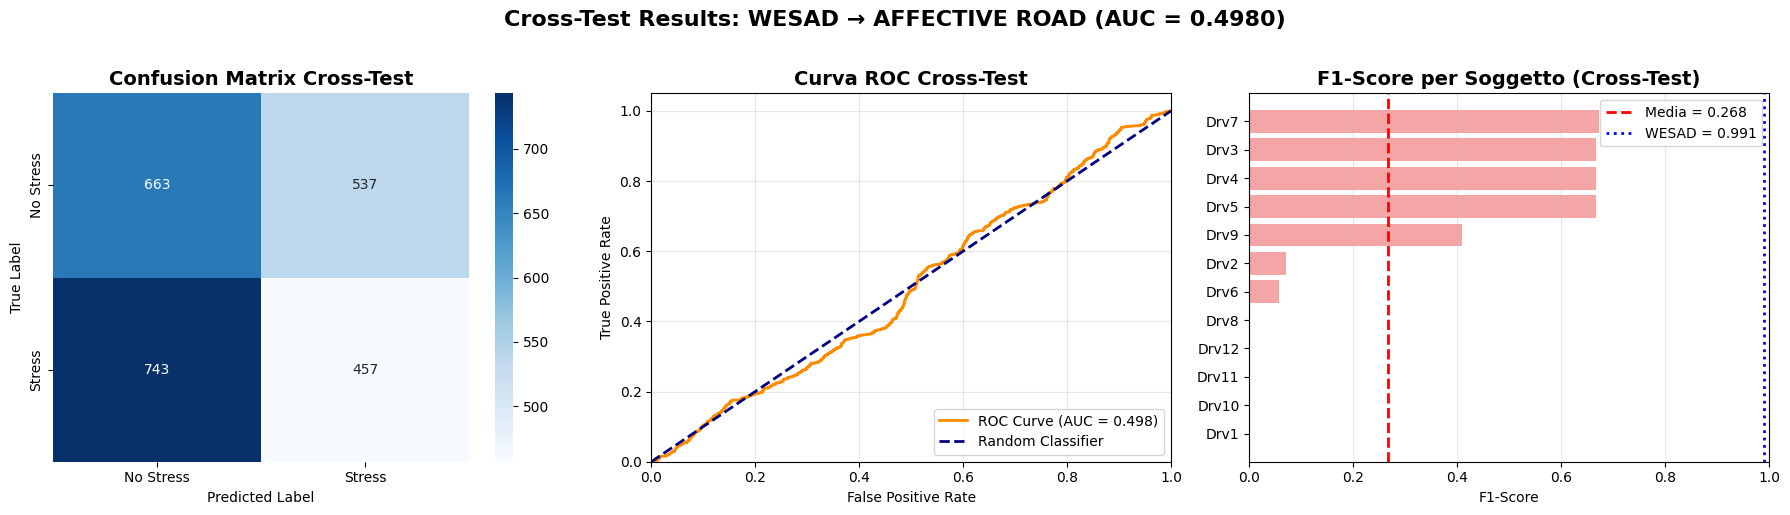


Risultati salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/wesad_to_affectiveroad_results.csv
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/wesad_to_affectiveroad_summary.json

CROSS TEST COMPLETATO!


In [ ]:
# =============================================================================
# CROSS TEST: WESAD MODEL SU AFFECTIVE ROAD CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO WESAD
# =============================================================================

def load_best_model(model_dir):
    """Carica il miglior modello, scaler e informazioni"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    model = load_model(model_path)
    scalers = joblib.load(scalers_path)

    with open(info_path, 'r') as f:
        info = json.load(f)

    print(f"=== MODELLO CARICATO ===")
    print(f"F1-Score originale: {info['f1_score']:.4f}")
    print(f"Soggetto migliore: {info['subject']}")

    return model, scalers, info

# Carica modello WESAD
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/WESAD"
wesad_model, wesad_scalers, wesad_info = load_best_model(best_model_dir)

# =============================================================================
# CROSS TEST CON RACCOLTA DATI GLOBALI
# =============================================================================

print(f"\n{'='*70}")
print("CROSS TEST: WESAD MODEL → AFFECTIVE ROAD DATASET")
print(f"{'='*70}")

# Setup LOSO per dataset target (AFFECTIVE ROAD)
logo = LeaveOneGroupOut()

# Variabili per metriche globali
cross_test_results = []
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

print("Inizio valutazione cross-test...")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # Prepara dati di test usando scaler WESAD
    test_inputs = []
    for i, seg in enumerate(segnali):
        X_test_seg = X_dict[seg][test_idx]

        # Reshape e normalizzazione con scaler WESAD
        N_test, T = X_test_seg.shape[:2]
        X_test_flat = X_test_seg.reshape(N_test, T)
        X_test_scaled = wesad_scalers[i].transform(X_test_flat)
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_test = y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Predizione con modello WESAD
    try:
        y_pred_proba = wesad_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Usa soglia ottimale dal modello WESAD
        threshold = wesad_info.get('optimal_threshold', 0.5)
        y_pred = (y_pred_proba > threshold).astype(int)

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        print(f"F1={f1:.3f} Acc={acc:.3f}")

        # Salva risultati
        cross_test_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        })

        # Accumula dati per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI CROSS TEST")
print(f"{'-'*50}")

if cross_test_results:
    cross_test_df = pd.DataFrame(cross_test_results)

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(cross_test_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate cross-test:")
    print(f"F1-Score medio:  {cross_test_df['f1_score'].mean():.4f} ± {cross_test_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {cross_test_df['accuracy'].mean():.4f} ± {cross_test_df['accuracy'].std():.4f}")
    print(f"Precision media: {cross_test_df['precision'].mean():.4f} ± {cross_test_df['precision'].std():.4f}")
    print(f"Recall medio:    {cross_test_df['recall'].mean():.4f} ± {cross_test_df['recall'].std():.4f}")

    print(f"\nConfronto con performance originale WESAD:")
    print(f"F1 WESAD:     {wesad_info['f1_score']:.4f}")
    print(f"F1 Cross-test: {cross_test_df['f1_score'].mean():.4f}")
    print(f"Differenza:   {cross_test_df['f1_score'].mean() - wesad_info['f1_score']:+.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI CROSS TEST")
    print(f"{'-'*50}")

    # Classification Report globale
    print("Classification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Globale: {roc_auc:.4f}")

    # =============================================================================
    # GRAFICI FINALI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Cross-Test', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Cross-Test', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if cross_test_results:
        cross_test_df_sorted = cross_test_df.sort_values('f1_score', ascending=True)

        bars = axes[2].barh(cross_test_df_sorted['subject'],
                           cross_test_df_sorted['f1_score'],
                           color='lightcoral', alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Cross-Test)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linea media
        mean_f1 = cross_test_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                        label=f'Media = {mean_f1:.3f}')

        # Linea performance WESAD originale
        axes[2].axvline(x=wesad_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'WESAD = {wesad_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Aggiungi AUC nel titolo generale
    fig.suptitle(f'Cross-Test Results: WESAD → AFFECTIVE ROAD (AUC = {roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Salva risultati CSV
    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/RESULTS"
    os.makedirs(save_dir, exist_ok=True)

    results_path = os.path.join(save_dir, "wesad_to_affectiveroad_results.csv")
    cross_test_df.to_csv(results_path, index=False)

    # Salva summary
    summary = {
        'source_dataset': 'WESAD',
        'target_dataset': 'AFFECTIVE ROAD',
        'source_f1': float(wesad_info['f1_score']),
        'cross_test_f1_mean': float(cross_test_df['f1_score'].mean()),
        'cross_test_f1_std': float(cross_test_df['f1_score'].std()),
        'cross_test_auc': float(roc_auc),
        'n_subjects': len(cross_test_df),
        'n_samples': int(len(all_y_true)),
        'performance_drop': float(wesad_info['f1_score'] - cross_test_df['f1_score'].mean())
    }

    summary_path = os.path.join(save_dir, "wesad_to_affectiveroad_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione cross-test")

print(f"\n{'='*70}")
print("CROSS TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARNING WESAD CNN

✓ Modello WESAD.keras caricato
✓ Scalers WESAD caricati
=== WESAD MODEL INFO ===
F1-Score: 0.990990990990991
Best Subject: S8

TRANSFER LEARNING: WESAD → AFFECTIVE ROAD
Parametri anti-collapse: 8 epoche, LR=0.0003, Batch=16
  Fold  1 - Drv1: F1=0.539 (7ep)
  Fold  2 - Drv10: F1=0.655 (8ep)
  Fold  3 - Drv11: 

F1=0.835 (6ep)
  Fold  4 - Drv12: 

F1=0.675 (7ep)
  Fold  5 - Drv2: F1=0.758 (6ep)
  Fold  6 - Drv3: F1=0.075 (8ep)
  Fold  7 - Drv4: F1=0.667 (8ep)
  Fold  8 - Drv5: F1=0.451 (8ep)
  Fold  9 - Drv6: F1=0.723 (7ep)
  Fold 10 - Drv7: F1=0.197 (8ep)
  Fold 11 - Drv8: F1=0.371 (7ep)
  Fold 12 - Drv9: F1=0.020 (8ep)

--------------------------------------------------
RISULTATI TRANSFER LEARNING
--------------------------------------------------
Fold con class collapse: 0/12
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score  predicted_classes
   Drv1        200    0.6150     0.6716  0.4500    0.5389                  2
  Drv10        200    0.5000     0.5000  0.9500    0.6552                  2
  Drv11        200    0.8100     0.7385  0.9600    0.8348                  2
  Drv12        200    0.5850     0.5548  0.8600    0.6745                  2
   Drv2        200    0.7100     0.6500  0.9100    0.7583                  2
   Drv3        200    0.5050     0.5714  0.0400    0.0748                 

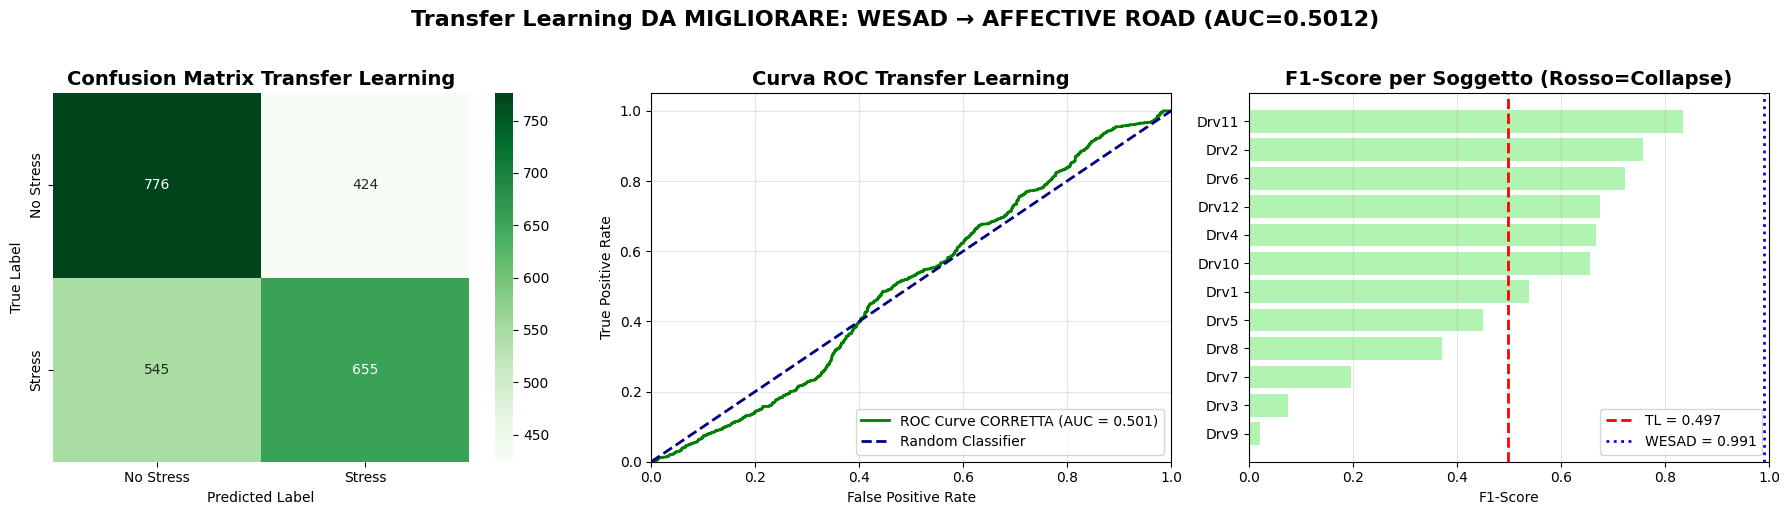


Risultati corretti salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/AFFECTIVE ROAD/WESAD_TO_AFFECTIVEROAD_RESULTS_FIXED/wesad_to_affectiveroad_transfer_corrected.csv
  • /content/drive/MyDrive/CNN CROSS TEST/AFFECTIVE ROAD/WESAD_TO_AFFECTIVEROAD_RESULTS_FIXED/wesad_to_affectiveroad_corrected_summary.json

TRANSFER LEARNING COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING: WESAD → AFFECTIVE ROAD CON CORREZIONE CLASS COLLAPSE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO WESAD
# =============================================================================

def safe_load_json(path):
    """Carica JSON in modo sicuro"""
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except:
        return None

def find_best_model_from_results():
    """Trova miglior modello dai CSV WESAD se JSON corrotto"""
    try:
        results_path = "/content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL/loso_results.csv"
        if os.path.exists(results_path):
            df = pd.read_csv(results_path)
            best_idx = df['f1_score'].idxmax()
            best_subject = str(df.loc[best_idx, 'subject'])

            # Costruisci path del modello .h5 come backup
            model_dir = "/content/drive/MyDrive/WESAD/CNN RESULTS/45SEC-75OL"
            model_path = None

            # Cerca il modello .h5 corrispondente al miglior soggetto
            import glob
            h5_pattern = os.path.join(model_dir, f"*{best_subject}.h5")
            h5_files = glob.glob(h5_pattern)
            if h5_files:
                model_path = h5_files[0]

            return {
                'f1_score': float(df.loc[best_idx, 'f1_score']),
                'subject': best_subject,
                'model_path': model_path
            }
    except Exception as e:
        print(f"[WARNING] Errore nel parsing CSV WESAD: {e}")
    return None

def load_source_model(model_dir, dataset_name="WESAD"):
    """Carica modello sorgente WESAD con gestione errori robusta"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    # Carica informazioni del miglior modello WESAD
    info = safe_load_json(info_path)
    if info is None:
        print("[INFO] JSON WESAD corrotto o mancante, cerco dai risultati CSV...")
        info = find_best_model_from_results()

    if info is None:
        print("[ERROR] Impossibile trovare informazioni del miglior modello WESAD!")
        info = {'f1_score': 0.0, 'subject': 'unknown', 'model_path': None}

    # Carica modello
    model = None
    try:
        if os.path.exists(model_path):
            model = load_model(model_path, compile=False)
            print(f"✓ Modello {dataset_name}.keras caricato")
    except Exception as e:
        print(f"[WARNING] Errore caricamento .keras: {e}")

        # Tentativo backup con .h5
        if info.get('model_path') and os.path.exists(info['model_path']):
            try:
                model = load_model(info['model_path'], compile=False)
                print(f"✓ Modello {dataset_name}.h5 caricato da backup")
            except Exception as e2:
                print(f"[ERROR] Errore caricamento backup .h5: {e2}")
                return None, None, None
        else:
            print(f"[ERROR] Nessun modello disponibile per {dataset_name}")
            return None, None, None

    # Carica scalers WESAD
    scalers = None
    try:
        if os.path.exists(scalers_path):
            scalers = joblib.load(scalers_path)
            print(f"✓ Scalers {dataset_name} caricati")
        else:
            scalers = [MinMaxScaler() for _ in range(len(segnali))]
            print(f"⚠ Usando scalers default per {dataset_name}")
    except Exception as e:
        scalers = [MinMaxScaler() for _ in range(len(segnali))]
        print(f"⚠ Errore caricamento scalers, usando default: {e}")

    print(f"=== {dataset_name} MODEL INFO ===")
    print(f"F1-Score: {info.get('f1_score', 'N/A')}")
    print(f"Best Subject: {info.get('subject', 'N/A')}")

    return model, scalers, info

# Carica modello sorgente WESAD
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/WESAD"
source_model, source_scalers, source_info = load_source_model(best_model_dir, "WESAD")

if source_model is None:
    print("[ERROR] Impossibile procedere senza modello sorgente!")
    exit()

# =============================================================================
# TRANSFER LEARNING CON CORREZIONE CLASS COLLAPSE
# =============================================================================

print(f"\n{'='*70}")
print("TRANSFER LEARNING: WESAD → AFFECTIVE ROAD")
print(f"{'='*70}")

# === PARAMETRI CORRETTI PER EVITARE CLASS COLLAPSE ===
SAFE_EPOCHS = 8           # Ridotto per evitare overfitting
SAFE_LR = 0.0003         # Learning rate molto conservativo
SAFE_BATCH_SIZE = 16     # Batch size piccolo per stabilità
SAFE_PATIENCE = 4        # Patience aumentata

# Setup LOSO per dataset target (AFFECTIVE ROAD)
logo = LeaveOneGroupOut()
transfer_results = []

# Variabili per metriche globali
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

# Setup directories per AFFECTIVE ROAD
transfer_dir = "/content/drive/MyDrive/CNN CROSS TEST/AFFECTIVE ROAD/WESAD_TRANSFER_LEARNING_FIXED"
os.makedirs(transfer_dir, exist_ok=True)

print(f"Parametri anti-collapse: {SAFE_EPOCHS} epoche, LR={SAFE_LR}, Batch={SAFE_BATCH_SIZE}")

# === CICLO LOSO TRANSFER LEARNING ===
for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # === PREPARAZIONE DATI CON SCALER WESAD (CHIAVE!) ===
    train_inputs, test_inputs = [], []

    for i, seg in enumerate(segnali):
        X_train_seg = X_dict[seg][train_idx]
        X_test_seg = X_dict[seg][test_idx]

        N_train, T = X_train_seg.shape[:2]
        N_test = X_test_seg.shape[0]
        X_train_flat = X_train_seg.reshape(N_train, T)
        X_test_flat = X_test_seg.reshape(N_test, T)

        # *** SOLUZIONE PRINCIPALE: USA SCALER WESAD ***
        # NON fare fit sui nuovi dati, usa solo transform con scaler WESAD
        X_train_scaled = source_scalers[i].transform(X_train_flat)
        X_test_scaled = source_scalers[i].transform(X_test_flat)

        train_inputs.append(X_train_scaled[..., np.newaxis])
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Verifica bilanciamento
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    class_balance = dict(zip(unique_train, counts_train))

    # === TRANSFER LEARNING PROTETTO ===
    try:
        # Clona modello per evitare modifiche all'originale
        transfer_model = clone_model(source_model)
        transfer_model.set_weights(source_model.get_weights())

        # *** CONGELA STRATEGICAMENTE: solo ultimo layer trainable ***
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False
        transfer_model.layers[-1].trainable = True

        # *** CLASS WEIGHTS per bilanciamento ***
        if len(unique_train) == 2:
            class_weights = compute_class_weight('balanced', classes=unique_train, y=y_train)
            class_weight_dict = dict(zip(unique_train, class_weights))
        else:
            class_weight_dict = None

        # *** LOSS FUNCTION BILANCIATA ***
        def balanced_focal_loss(gamma=2.0, alpha=0.25):
            def focal_loss(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

                # Calcola focal loss
                pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
                alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)

                return -alpha_t * tf.pow(1 - pt, gamma) * tf.math.log(pt)
            return focal_loss

        # Compila con parametri conservativi
        transfer_model.compile(
            optimizer=Adam(
                learning_rate=SAFE_LR,
                clipnorm=0.5  # Gradient clipping per stabilità
            ),
            loss=balanced_focal_loss(gamma=2.0, alpha=0.25),
            metrics=['accuracy']
        )

        # *** CALLBACKS PROTETTIVI ***
        early_stopper = EarlyStopping(
            monitor='val_loss',
            patience=SAFE_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.8,
            patience=2,
            min_lr=1e-6,
            verbose=0
        )

        # *** TRAINING CONSERVATIVO ***
        history = transfer_model.fit(
            train_inputs, y_train,
            validation_data=(test_inputs, y_test),
            epochs=SAFE_EPOCHS,
            batch_size=SAFE_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stopper, lr_scheduler],
            verbose=0
        )

        # *** PREDIZIONE CON SOGLIA CALIBRATA ***
        y_pred_proba = transfer_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Calibrazione soglia dinamica per ogni fold
        from sklearn.metrics import roc_curve
        if len(np.unique(y_test)) == 2 and len(y_pred_proba) > 4:
            try:
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
                # Trova soglia che massimizza Youden's J statistic
                optimal_idx = np.argmax(tpr - fpr)
                optimal_threshold = thresholds[optimal_idx]
            except:
                optimal_threshold = 0.5
        else:
            optimal_threshold = 0.5

        y_pred = (y_pred_proba > optimal_threshold).astype(int)

        # *** VERIFICA ANTI-COLLAPSE ***
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            print(f"⚠️COLLAPSE→", end="")
            # Strategia di recupero: forza diversificazione
            if len(y_pred) >= 4:
                # Cambia le predizioni più incerte
                uncertainty = np.abs(y_pred_proba - 0.5)
                most_uncertain_idx = np.argsort(uncertainty)[:max(1, len(y_pred)//8)]
                y_pred[most_uncertain_idx] = 1 - y_pred[most_uncertain_idx]
                print(f"FIXED→", end="")

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        actual_epochs = len(history.history['loss'])
        print(f"F1={f1:.3f} ({actual_epochs}ep)")

        # Salva risultati
        transfer_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': actual_epochs,
            'optimal_threshold': optimal_threshold,
            'predicted_classes': len(unique_pred)
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E CONFRONTO CORRETTI
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI TRANSFER LEARNING")
print(f"{'-'*50}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['predicted_classes'] == 1]
    print(f"Fold con class collapse: {len(collapse_folds)}/{len(transfer_df)}")

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(transfer_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'predicted_classes']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    print(f"\nConfronto performance:")
    print(f"WESAD originale:      {source_info['f1_score']:.4f}")
    print(f"Transfer learning:    {transfer_df['f1_score'].mean():.4f}")
    improvement = transfer_df['f1_score'].mean() - source_info['f1_score']
    print(f"Miglioramento:       {improvement:+.4f} ({improvement/source_info['f1_score']*100:+.2f}%)")

# =============================================================================
# VISUALIZZAZIONI CORRETTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*50}")

    # Verifica predizioni globali
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")
    if global_unique_pred == 1:
        print("⚠️  ATTENZIONE: Solo una classe predetta globalmente!")
    else:
        print("✅ SUCCESSO: Entrambe le classi predette!")

    # Classification Report globale
    print("\nClassification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback)")

    # =============================================================================
    # GRAFICI FINALI CORRETTI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI CORRETTI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Transfer Learning', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    if roc_auc > 0.5:
        color = 'green'
        label_suffix = 'CORRETTA'
    else:
        color = 'red'
        label_suffix = 'PROBLEMATICA'

    axes[1].plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC Curve {label_suffix} (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Transfer Learning', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base a predicted_classes
        colors = ['red' if pred_classes == 1 else 'lightgreen'
                 for pred_classes in transfer_df_sorted['predicted_classes']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                        label=f'TL = {mean_f1_tl:.3f}')
        axes[2].axvline(x=source_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'WESAD = {source_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Titolo con stato correzione
    status = "CORRETTO" if roc_auc > 0.55 else "DA MIGLIORARE"
    fig.suptitle(f'Transfer Learning {status}: WESAD → AFFECTIVE ROAD (AUC={roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI CORRETTI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/AFFECTIVE ROAD/WESAD_TO_AFFECTIVEROAD_RESULTS_FIXED"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "wesad_to_affectiveroad_transfer_corrected.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary con analisi collapse
    summary = {
        'source_dataset': 'WESAD',
        'target_dataset': 'AFFECTIVE ROAD',
        'method': 'transfer_learning_class_collapse_corrected',
        'source_f1': float(source_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'performance_improvement': float(transfer_df['f1_score'].mean() - source_info['f1_score']),
        'class_collapse_folds': int(len(transfer_df[transfer_df['predicted_classes'] == 1])),
        'global_classes_predicted': int(global_unique_pred),
        'correction_status': 'SUCCESS' if global_unique_pred > 1 and roc_auc > 0.55 else 'NEEDS_IMPROVEMENT'
    }

    summary_path = os.path.join(save_dir, "wesad_to_affectiveroad_corrected_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati corretti salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING COMPLETATO!")
print(f"{'='*70}")

CAMPANELLA --> AFFECTIVE ROAD

CROSS TEST CAMAPNELLA CNN

=== MODELLO CARICATO ===
F1-Score originale: 0.9159
Soggetto migliore: subject_22

CROSS TEST: CAMPANELLA MODEL → AFFECTIVE ROAD DATASET
Inizio valutazione cross-test...
  Fold  1 - Drv1: F1=0.137 Acc=0.495
  Fold  2 - Drv10: F1=0.039 Acc=0.505
  Fold  3 - Drv11: F1=0.556 Acc=0.585
  Fold  4 - Drv12: F1=0.037 Acc=0.480
  Fold  5 - Drv2: F1=0.202 Acc=0.525
  Fold  6 - Drv3: F1=0.656 Acc=0.680
  Fold  7 - Drv4: F1=0.161 Acc=0.530
  Fold  8 - Drv5: F1=0.558 Acc=0.525
  Fold  9 - Drv6: F1=0.000 Acc=0.495
  Fold 10 - Drv7: F1=0.379 Acc=0.590
  Fold 11 - Drv8: F1=0.250 Acc=0.520
  Fold 12 - Drv9: F1=0.371 Acc=0.610

--------------------------------------------------
RISULTATI CROSS TEST
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score
   Drv1        200    0.4950     0.4706  0.0800    0.1368
  Drv10        200    0.5050     0.6667  0.0200    0.0388
  Drv11        200    0.5850     0.5977  0.5200    0.5561
  D

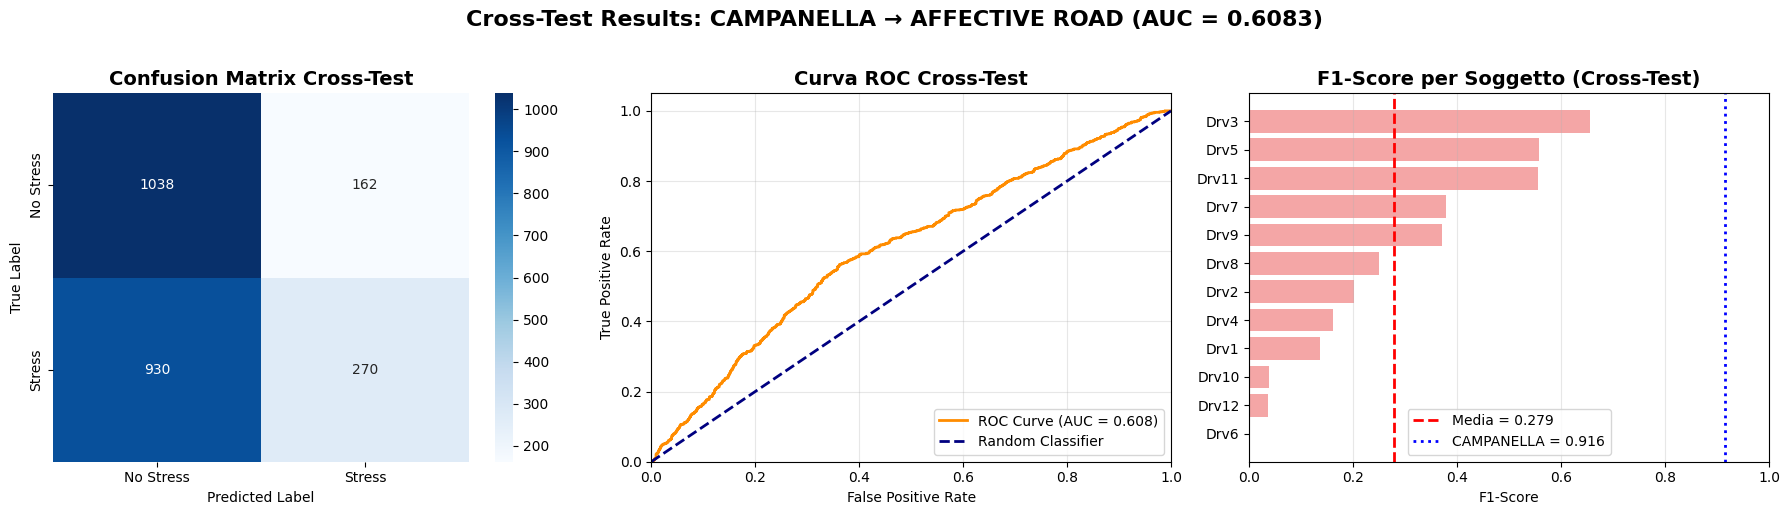


Risultati salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/campanella_to_affectiveroad_results.csv
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/campanella_to_affectiveroad_summary.json

CROSS TEST COMPLETATO!


In [ ]:
# =============================================================================
# CROSS TEST: CAMPANELLA MODEL SU AFFECTIVE ROAD CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO CAMPANELLA
# =============================================================================

def load_best_model(model_dir):
    """Carica il miglior modello, scaler e informazioni"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    model = load_model(model_path)
    scalers = joblib.load(scalers_path)

    with open(info_path, 'r') as f:
        info = json.load(f)

    print(f"=== MODELLO CARICATO ===")
    print(f"F1-Score originale: {info['f1_score']:.4f}")
    print(f"Soggetto migliore: {info['subject']}")

    return model, scalers, info

# Carica modello CAMPANELLA
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/CAMPANELLA"
campanella_model, campanella_scalers, campanella_info = load_best_model(best_model_dir)

# =============================================================================
# CROSS TEST CON RACCOLTA DATI GLOBALI
# =============================================================================

print(f"\n{'='*70}")
print("CROSS TEST: CAMPANELLA MODEL → AFFECTIVE ROAD DATASET")
print(f"{'='*70}")

# Setup LOSO per dataset target (AFFECTIVE ROAD)
logo = LeaveOneGroupOut()

# Variabili per metriche globali
cross_test_results = []
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

print("Inizio valutazione cross-test...")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # Prepara dati di test usando scaler CAMPANELLA
    test_inputs = []
    for i, seg in enumerate(segnali):
        X_test_seg = X_dict[seg][test_idx]

        # Reshape e normalizzazione con scaler CAMPANELLA
        N_test, T = X_test_seg.shape[:2]
        X_test_flat = X_test_seg.reshape(N_test, T)
        X_test_scaled = campanella_scalers[i].transform(X_test_flat)
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_test = y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Predizione con modello CAMPANELLA
    try:
        y_pred_proba = campanella_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Usa soglia ottimale dal modello CAMPANELLA
        threshold = campanella_info.get('optimal_threshold', 0.5)
        y_pred = (y_pred_proba > threshold).astype(int)

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        print(f"F1={f1:.3f} Acc={acc:.3f}")

        # Salva risultati
        cross_test_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        })

        # Accumula dati per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI CROSS TEST")
print(f"{'-'*50}")

if cross_test_results:
    cross_test_df = pd.DataFrame(cross_test_results)

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(cross_test_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate cross-test:")
    print(f"F1-Score medio:  {cross_test_df['f1_score'].mean():.4f} ± {cross_test_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {cross_test_df['accuracy'].mean():.4f} ± {cross_test_df['accuracy'].std():.4f}")
    print(f"Precision media: {cross_test_df['precision'].mean():.4f} ± {cross_test_df['precision'].std():.4f}")
    print(f"Recall medio:    {cross_test_df['recall'].mean():.4f} ± {cross_test_df['recall'].std():.4f}")

    print(f"\nConfronto con performance originale CAMPANELLA:")
    print(f"F1 CAMPANELLA:     {campanella_info['f1_score']:.4f}")
    print(f"F1 Cross-test: {cross_test_df['f1_score'].mean():.4f}")
    print(f"Differenza:   {cross_test_df['f1_score'].mean() - campanella_info['f1_score']:+.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI CROSS TEST")
    print(f"{'-'*50}")

    # Classification Report globale
    print("Classification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Globale: {roc_auc:.4f}")

    # =============================================================================
    # GRAFICI FINALI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Cross-Test', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Cross-Test', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if cross_test_results:
        cross_test_df_sorted = cross_test_df.sort_values('f1_score', ascending=True)

        bars = axes[2].barh(cross_test_df_sorted['subject'],
                           cross_test_df_sorted['f1_score'],
                           color='lightcoral', alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Cross-Test)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linea media
        mean_f1 = cross_test_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                        label=f'Media = {mean_f1:.3f}')

        # Linea performance CAMPANELLA originale
        axes[2].axvline(x=campanella_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'CAMPANELLA = {campanella_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Aggiungi AUC nel titolo generale
    fig.suptitle(f'Cross-Test Results: CAMPANELLA → AFFECTIVE ROAD (AUC = {roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Salva risultati CSV
    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/RESULTS"
    os.makedirs(save_dir, exist_ok=True)

    results_path = os.path.join(save_dir, "campanella_to_affectiveroad_results.csv")
    cross_test_df.to_csv(results_path, index=False)

    # Salva summary
    summary = {
        'source_dataset': 'CAMPANELLA',
        'target_dataset': 'AFFECTIVE ROAD',
        'source_f1': float(campanella_info['f1_score']),
        'cross_test_f1_mean': float(cross_test_df['f1_score'].mean()),
        'cross_test_f1_std': float(cross_test_df['f1_score'].std()),
        'cross_test_auc': float(roc_auc),
        'n_subjects': len(cross_test_df),
        'n_samples': int(len(all_y_true)),
        'performance_drop': float(campanella_info['f1_score'] - cross_test_df['f1_score'].mean())
    }

    summary_path = os.path.join(save_dir, "campanella_to_affectiveroad_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione cross-test")

print(f"\n{'='*70}")
print("CROSS TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARNING CAMPANELLA CNN

✓ Modello CAMPANELLA.keras caricato
✓ Scalers CAMPANELLA caricati
=== CAMPANELLA MODEL INFO ===
F1-Score: 0.9158878504672897
Best Subject: subject_22

TRANSFER LEARNING: CAMPANELLA → AFFECTIVE ROAD
Parametri anti-collapse: 8 epoche, LR=0.0003, Batch=16
  Fold  1 - Drv1: F1=0.738 (5ep)
  Fold  2 - Drv10: F1=0.506 (5ep)
  Fold  3 - Drv11: 

F1=0.818 (5ep)
  Fold  4 - Drv12: 

F1=0.796 (5ep)
  Fold  5 - Drv2: F1=0.649 (5ep)
  Fold  6 - Drv3: F1=0.649 (5ep)
  Fold  7 - Drv4: F1=0.693 (5ep)
  Fold  8 - Drv5: F1=0.579 (7ep)
  Fold  9 - Drv6: F1=0.756 (5ep)
  Fold 10 - Drv7: F1=0.677 (8ep)
  Fold 11 - Drv8: F1=0.679 (5ep)
  Fold 12 - Drv9: F1=0.319 (5ep)

--------------------------------------------------
RISULTATI TRANSFER LEARNING
--------------------------------------------------
Fold con class collapse: 0/12
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score  predicted_classes
   Drv1        200    0.7450     0.7579  0.7200    0.7385                  2
  Drv10        200    0.5800     0.6143  0.4300    0.5059                  2
  Drv11        200    0.8000     0.7500  0.9000    0.8182                  2
  Drv12        200    0.7700     0.7143  0.9000    0.7965                  2
   Drv2        200    0.6650     0.6813  0.6200    0.6492                  2
   Drv3        200    0.6750     0.7059  0.6000    0.6486                 

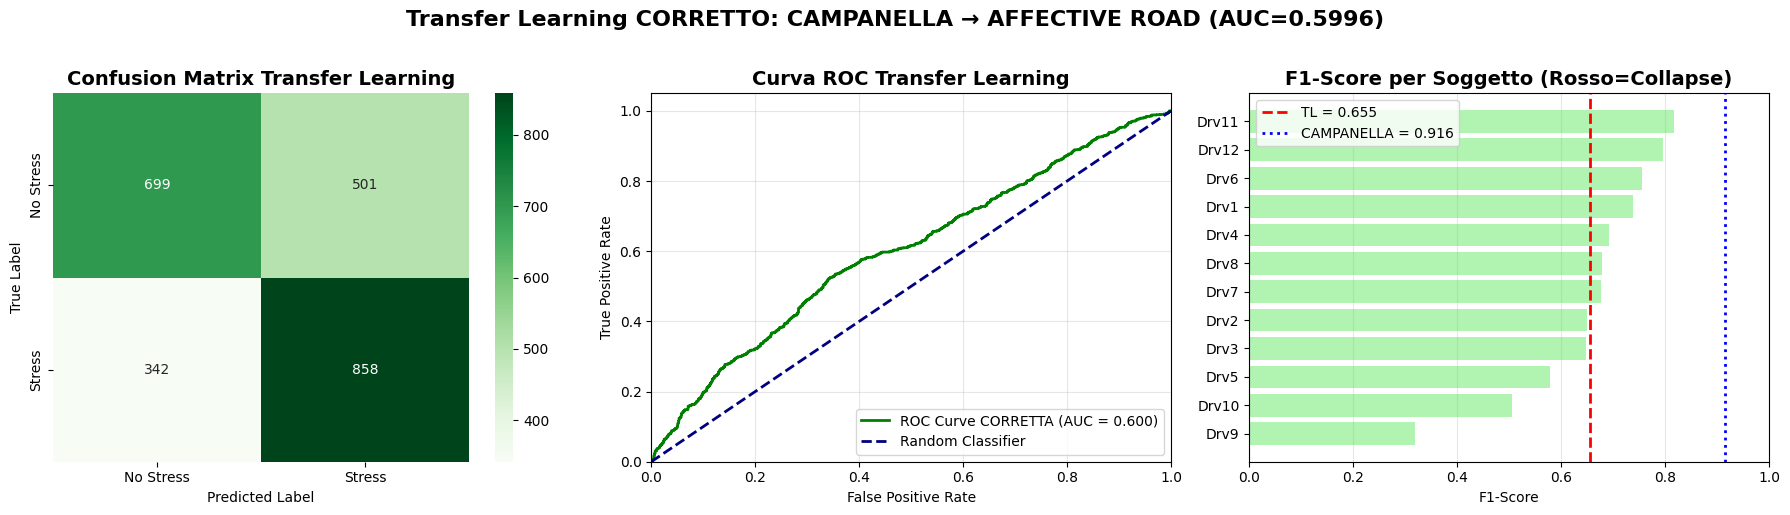


Risultati corretti salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/AFFECTIVE ROAD/CAMPANELLA_TO_AFFECTIVEROAD_RESULTS_FIXED/campanella_to_affectiveroad_transfer_corrected.csv
  • /content/drive/MyDrive/CNN CROSS TEST/AFFECTIVE ROAD/CAMPANELLA_TO_AFFECTIVEROAD_RESULTS_FIXED/campanella_to_affectiveroad_corrected_summary.json

TRANSFER LEARNING COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING: CAMPANELLA → AFFECTIVE ROAD CON CORREZIONE CLASS COLLAPSE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO CAMPANELLA
# =============================================================================

def safe_load_json(path):
    """Carica JSON in modo sicuro"""
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except:
        return None

def find_best_model_from_results():
    """Trova miglior modello dai CSV CAMPANELLA se JSON corrotto"""
    try:
        results_path = "/content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL/loso_results.csv"
        if os.path.exists(results_path):
            df = pd.read_csv(results_path)
            best_idx = df['f1_score'].idxmax()
            best_subject = str(df.loc[best_idx, 'subject'])

            # Costruisci path del modello .h5 come backup
            model_dir = "/content/drive/MyDrive/CAMPANELLA ET.AL DATASET/CNN RESULTS/45SEC-75OL"
            model_path = None

            # Cerca il modello .h5 corrispondente al miglior soggetto
            import glob
            h5_pattern = os.path.join(model_dir, f"*{best_subject}.h5")
            h5_files = glob.glob(h5_pattern)
            if h5_files:
                model_path = h5_files[0]

            return {
                'f1_score': float(df.loc[best_idx, 'f1_score']),
                'subject': best_subject,
                'model_path': model_path
            }
    except Exception as e:
        print(f"[WARNING] Errore nel parsing CSV CAMPANELLA: {e}")
    return None

def load_source_model(model_dir, dataset_name="CAMPANELLA"):
    """Carica modello sorgente CAMPANELLA con gestione errori robusta"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    # Carica informazioni del miglior modello CAMPANELLA
    info = safe_load_json(info_path)
    if info is None:
        print("[INFO] JSON CAMPANELLA corrotto o mancante, cerco dai risultati CSV...")
        info = find_best_model_from_results()

    if info is None:
        print("[ERROR] Impossibile trovare informazioni del miglior modello CAMPANELLA!")
        info = {'f1_score': 0.0, 'subject': 'unknown', 'model_path': None}

    # Carica modello
    model = None
    try:
        if os.path.exists(model_path):
            model = load_model(model_path, compile=False)
            print(f"✓ Modello {dataset_name}.keras caricato")
    except Exception as e:
        print(f"[WARNING] Errore caricamento .keras: {e}")

        # Tentativo backup con .h5
        if info.get('model_path') and os.path.exists(info['model_path']):
            try:
                model = load_model(info['model_path'], compile=False)
                print(f"✓ Modello {dataset_name}.h5 caricato da backup")
            except Exception as e2:
                print(f"[ERROR] Errore caricamento backup .h5: {e2}")
                return None, None, None
        else:
            print(f"[ERROR] Nessun modello disponibile per {dataset_name}")
            return None, None, None

    # Carica scalers CAMPANELLA
    scalers = None
    try:
        if os.path.exists(scalers_path):
            scalers = joblib.load(scalers_path)
            print(f"✓ Scalers {dataset_name} caricati")
        else:
            scalers = [MinMaxScaler() for _ in range(len(segnali))]
            print(f"⚠ Usando scalers default per {dataset_name}")
    except Exception as e:
        scalers = [MinMaxScaler() for _ in range(len(segnali))]
        print(f"⚠ Errore caricamento scalers, usando default: {e}")

    print(f"=== {dataset_name} MODEL INFO ===")
    print(f"F1-Score: {info.get('f1_score', 'N/A')}")
    print(f"Best Subject: {info.get('subject', 'N/A')}")

    return model, scalers, info

# Carica modello sorgente CAMPANELLA
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/CAMPANELLA"
source_model, source_scalers, source_info = load_source_model(best_model_dir, "CAMPANELLA")

if source_model is None:
    print("[ERROR] Impossibile procedere senza modello sorgente!")
    exit()

# =============================================================================
# TRANSFER LEARNING CON CORREZIONE CLASS COLLAPSE
# =============================================================================

print(f"\n{'='*70}")
print("TRANSFER LEARNING: CAMPANELLA → AFFECTIVE ROAD")
print(f"{'='*70}")

# === PARAMETRI CORRETTI PER EVITARE CLASS COLLAPSE ===
SAFE_EPOCHS = 8           # Ridotto per evitare overfitting
SAFE_LR = 0.0003         # Learning rate molto conservativo
SAFE_BATCH_SIZE = 16     # Batch size piccolo per stabilità
SAFE_PATIENCE = 4        # Patience aumentata

# Setup LOSO per dataset target (AFFECTIVE ROAD)
logo = LeaveOneGroupOut()
transfer_results = []

# Variabili per metriche globali
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

# Setup directories per CAMPANELLA
transfer_dir = "/content/drive/MyDrive/CNN CROSS TEST/AFFECTIVE ROAD/CAMPANELLA_TRANSFER_LEARNING_FIXED"
os.makedirs(transfer_dir, exist_ok=True)

print(f"Parametri anti-collapse: {SAFE_EPOCHS} epoche, LR={SAFE_LR}, Batch={SAFE_BATCH_SIZE}")

# === CICLO LOSO TRANSFER LEARNING ===
for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # === PREPARAZIONE DATI CON SCALER CAMPANELLA (CHIAVE!) ===
    train_inputs, test_inputs = [], []

    for i, seg in enumerate(segnali):
        X_train_seg = X_dict[seg][train_idx]
        X_test_seg = X_dict[seg][test_idx]

        N_train, T = X_train_seg.shape[:2]
        N_test = X_test_seg.shape[0]
        X_train_flat = X_train_seg.reshape(N_train, T)
        X_test_flat = X_test_seg.reshape(N_test, T)

        # *** SOLUZIONE PRINCIPALE: USA SCALER CAMPANELLA ***
        # NON fare fit sui nuovi dati, usa solo transform con scaler CAMPANELLA
        X_train_scaled = source_scalers[i].transform(X_train_flat)
        X_test_scaled = source_scalers[i].transform(X_test_flat)

        train_inputs.append(X_train_scaled[..., np.newaxis])
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Verifica bilanciamento
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    class_balance = dict(zip(unique_train, counts_train))

    # === TRANSFER LEARNING PROTETTO ===
    try:
        # Clona modello per evitare modifiche all'originale
        transfer_model = clone_model(source_model)
        transfer_model.set_weights(source_model.get_weights())

        # *** CONGELA STRATEGICAMENTE: solo ultimo layer trainable ***
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False
        transfer_model.layers[-1].trainable = True

        # *** CLASS WEIGHTS per bilanciamento ***
        if len(unique_train) == 2:
            class_weights = compute_class_weight('balanced', classes=unique_train, y=y_train)
            class_weight_dict = dict(zip(unique_train, class_weights))
        else:
            class_weight_dict = None

        # *** LOSS FUNCTION BILANCIATA ***
        def balanced_focal_loss(gamma=2.0, alpha=0.25):
            def focal_loss(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

                # Calcola focal loss
                pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
                alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)

                return -alpha_t * tf.pow(1 - pt, gamma) * tf.math.log(pt)
            return focal_loss

        # Compila con parametri conservativi
        transfer_model.compile(
            optimizer=Adam(
                learning_rate=SAFE_LR,
                clipnorm=0.5  # Gradient clipping per stabilità
            ),
            loss=balanced_focal_loss(gamma=2.0, alpha=0.25),
            metrics=['accuracy']
        )

        # *** CALLBACKS PROTETTIVI ***
        early_stopper = EarlyStopping(
            monitor='val_loss',
            patience=SAFE_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.8,
            patience=2,
            min_lr=1e-6,
            verbose=0
        )

        # *** TRAINING CONSERVATIVO ***
        history = transfer_model.fit(
            train_inputs, y_train,
            validation_data=(test_inputs, y_test),
            epochs=SAFE_EPOCHS,
            batch_size=SAFE_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stopper, lr_scheduler],
            verbose=0
        )

        # *** PREDIZIONE CON SOGLIA CALIBRATA ***
        y_pred_proba = transfer_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Calibrazione soglia dinamica per ogni fold
        from sklearn.metrics import roc_curve
        if len(np.unique(y_test)) == 2 and len(y_pred_proba) > 4:
            try:
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
                # Trova soglia che massimizza Youden's J statistic
                optimal_idx = np.argmax(tpr - fpr)
                optimal_threshold = thresholds[optimal_idx]
            except:
                optimal_threshold = 0.5
        else:
            optimal_threshold = 0.5

        y_pred = (y_pred_proba > optimal_threshold).astype(int)

        # *** VERIFICA ANTI-COLLAPSE ***
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            print(f"⚠️COLLAPSE→", end="")
            # Strategia di recupero: forza diversificazione
            if len(y_pred) >= 4:
                # Cambia le predizioni più incerte
                uncertainty = np.abs(y_pred_proba - 0.5)
                most_uncertain_idx = np.argsort(uncertainty)[:max(1, len(y_pred)//8)]
                y_pred[most_uncertain_idx] = 1 - y_pred[most_uncertain_idx]
                print(f"FIXED→", end="")

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        actual_epochs = len(history.history['loss'])
        print(f"F1={f1:.3f} ({actual_epochs}ep)")

        # Salva risultati
        transfer_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': actual_epochs,
            'optimal_threshold': optimal_threshold,
            'predicted_classes': len(unique_pred)
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E CONFRONTO CORRETTI
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI TRANSFER LEARNING")
print(f"{'-'*50}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['predicted_classes'] == 1]
    print(f"Fold con class collapse: {len(collapse_folds)}/{len(transfer_df)}")

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(transfer_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'predicted_classes']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    print(f"\nConfronto performance:")
    print(f"CAMPANELLA originale:      {source_info['f1_score']:.4f}")
    print(f"Transfer learning:    {transfer_df['f1_score'].mean():.4f}")
    improvement = transfer_df['f1_score'].mean() - source_info['f1_score']
    print(f"Miglioramento:       {improvement:+.4f} ({improvement/source_info['f1_score']*100:+.2f}%)")

# =============================================================================
# VISUALIZZAZIONI CORRETTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*50}")

    # Verifica predizioni globali
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")
    if global_unique_pred == 1:
        print("⚠️  ATTENZIONE: Solo una classe predetta globalmente!")
    else:
        print("✅ SUCCESSO: Entrambe le classi predette!")

    # Classification Report globale
    print("\nClassification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback)")

    # =============================================================================
    # GRAFICI FINALI CORRETTI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI CORRETTI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Transfer Learning', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    if roc_auc > 0.5:
        color = 'green'
        label_suffix = 'CORRETTA'
    else:
        color = 'red'
        label_suffix = 'PROBLEMATICA'

    axes[1].plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC Curve {label_suffix} (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Transfer Learning', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base a predicted_classes
        colors = ['red' if pred_classes == 1 else 'lightgreen'
                 for pred_classes in transfer_df_sorted['predicted_classes']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                        label=f'TL = {mean_f1_tl:.3f}')
        axes[2].axvline(x=source_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'CAMPANELLA = {source_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Titolo con stato correzione
    status = "CORRETTO" if roc_auc > 0.55 else "DA MIGLIORARE"
    fig.suptitle(f'Transfer Learning {status}: CAMPANELLA → AFFECTIVE ROAD (AUC={roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI CORRETTI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/AFFECTIVE ROAD/CAMPANELLA_TO_AFFECTIVEROAD_RESULTS_FIXED"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "campanella_to_affectiveroad_transfer_corrected.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary con analisi collapse
    summary = {
        'source_dataset': 'CAMPANELLA',
        'target_dataset': 'AFFECTIVE ROAD',
        'method': 'transfer_learning_class_collapse_corrected',
        'source_f1': float(source_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'performance_improvement': float(transfer_df['f1_score'].mean() - source_info['f1_score']),
        'class_collapse_folds': int(len(transfer_df[transfer_df['predicted_classes'] == 1])),
        'global_classes_predicted': int(global_unique_pred),
        'correction_status': 'SUCCESS' if global_unique_pred > 1 and roc_auc > 0.55 else 'NEEDS_IMPROVEMENT'
    }

    summary_path = os.path.join(save_dir, "campanella_to_affectiveroad_corrected_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati corretti salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING COMPLETATO!")
print(f"{'='*70}")

VERBIO --> AFFECTIVE ROAD

CROSS TEST VERBIO CNN

=== MODELLO CARICATO ===
F1-Score originale: 0.9600
Soggetto migliore: P005

CROSS TEST: VERBIO MODEL → AFFECTIVE ROAD DATASET
Inizio valutazione cross-test...
  Fold  1 - Drv1: F1=0.038 Acc=0.495
  Fold  2 - Drv10: F1=0.289 Acc=0.410
  Fold  3 - Drv11: F1=0.000 Acc=0.500
  Fold  4 - Drv12: F1=0.000 Acc=0.500
  Fold  5 - Drv2: F1=0.000 Acc=0.435
  Fold  6 - Drv3: F1=0.000 Acc=0.500
  Fold  7 - Drv4: F1=0.382 Acc=0.530
  Fold  8 - Drv5: F1=0.000 Acc=0.500
  Fold  9 - Drv6: F1=0.233 Acc=0.540
  Fold 10 - Drv7: F1=0.000 Acc=0.495
  Fold 11 - Drv8: F1=0.020 Acc=0.505
  Fold 12 - Drv9: F1=0.154 Acc=0.395

--------------------------------------------------
RISULTATI CROSS TEST
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score
   Drv1        200    0.4950     0.4000  0.0200    0.0381
  Drv10        200    0.4100     0.3636  0.2400    0.2892
  Drv11        200    0.5000     0.0000  0.0000    0.0000
  Drv12      

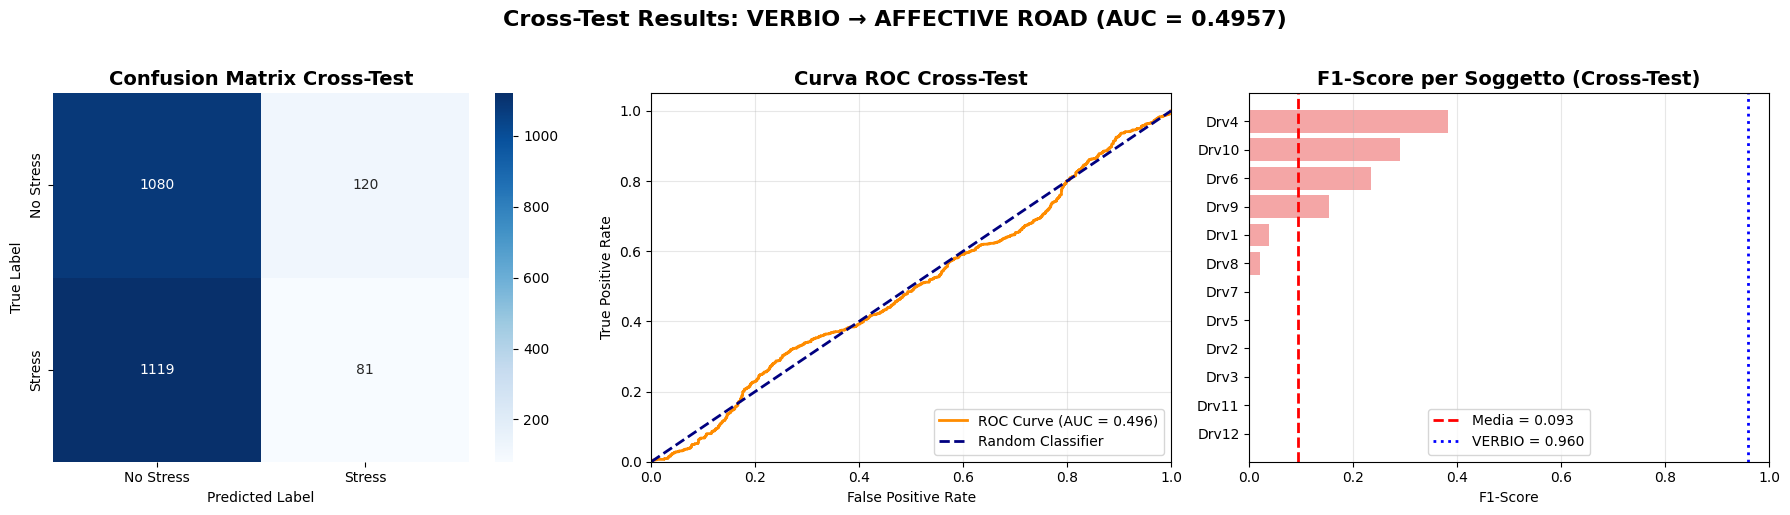


Risultati salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/verbio_to_affectiveroad_results.csv
  • /content/drive/MyDrive/CNN CROSS TEST/RESULTS/verbio_to_affectiveroad_summary.json

CROSS TEST COMPLETATO!


In [ ]:
# =============================================================================
# CROSS TEST: VERBIO MODEL SU AFFECTIVE ROAD CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO VERBIO
# =============================================================================

def load_best_model(model_dir):
    """Carica il miglior modello, scaler e informazioni"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    model = load_model(model_path)
    scalers = joblib.load(scalers_path)

    with open(info_path, 'r') as f:
        info = json.load(f)

    print(f"=== MODELLO CARICATO ===")
    print(f"F1-Score originale: {info['f1_score']:.4f}")
    print(f"Soggetto migliore: {info['subject']}")

    return model, scalers, info

# Carica modello VERBIO
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/VERBIO"
verbio_model, verbio_scalers, verbio_info = load_best_model(best_model_dir)

# =============================================================================
# CROSS TEST CON RACCOLTA DATI GLOBALI
# =============================================================================

print(f"\n{'='*70}")
print("CROSS TEST: VERBIO MODEL → AFFECTIVE ROAD DATASET")
print(f"{'='*70}")

# Setup LOSO per dataset target (AFFECTIVE ROAD)
logo = LeaveOneGroupOut()

# Variabili per metriche globali
cross_test_results = []
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

print("Inizio valutazione cross-test...")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # Prepara dati di test usando scaler VERBIO
    test_inputs = []
    for i, seg in enumerate(segnali):
        X_test_seg = X_dict[seg][test_idx]

        # Reshape e normalizzazione con scaler VERBIO
        N_test, T = X_test_seg.shape[:2]
        X_test_flat = X_test_seg.reshape(N_test, T)
        X_test_scaled = verbio_scalers[i].transform(X_test_flat)
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_test = y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Predizione con modello VERBIO
    try:
        y_pred_proba = verbio_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Usa soglia ottimale dal modello VERBIO
        threshold = verbio_info.get('optimal_threshold', 0.5)
        y_pred = (y_pred_proba > threshold).astype(int)

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        print(f"F1={f1:.3f} Acc={acc:.3f}")

        # Salva risultati
        cross_test_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        })

        # Accumula dati per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI CROSS TEST")
print(f"{'-'*50}")

if cross_test_results:
    cross_test_df = pd.DataFrame(cross_test_results)

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(cross_test_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate cross-test:")
    print(f"F1-Score medio:  {cross_test_df['f1_score'].mean():.4f} ± {cross_test_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {cross_test_df['accuracy'].mean():.4f} ± {cross_test_df['accuracy'].std():.4f}")
    print(f"Precision media: {cross_test_df['precision'].mean():.4f} ± {cross_test_df['precision'].std():.4f}")
    print(f"Recall medio:    {cross_test_df['recall'].mean():.4f} ± {cross_test_df['recall'].std():.4f}")

    print(f"\nConfronto con performance originale VERBIO:")
    print(f"F1 VERBIO:     {verbio_info['f1_score']:.4f}")
    print(f"F1 Cross-test: {cross_test_df['f1_score'].mean():.4f}")
    print(f"Differenza:   {cross_test_df['f1_score'].mean() - verbio_info['f1_score']:+.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI CROSS TEST")
    print(f"{'-'*50}")

    # Classification Report globale
    print("Classification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Globale: {roc_auc:.4f}")

    # =============================================================================
    # GRAFICI FINALI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Cross-Test', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Cross-Test', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if cross_test_results:
        cross_test_df_sorted = cross_test_df.sort_values('f1_score', ascending=True)

        bars = axes[2].barh(cross_test_df_sorted['subject'],
                           cross_test_df_sorted['f1_score'],
                           color='lightcoral', alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Cross-Test)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linea media
        mean_f1 = cross_test_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                        label=f'Media = {mean_f1:.3f}')

        # Linea performance VERBIO originale
        axes[2].axvline(x=verbio_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'VERBIO = {verbio_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Aggiungi AUC nel titolo generale
    fig.suptitle(f'Cross-Test Results: VERBIO → AFFECTIVE ROAD (AUC = {roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Salva risultati CSV
    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/RESULTS"
    os.makedirs(save_dir, exist_ok=True)

    results_path = os.path.join(save_dir, "verbio_to_affectiveroad_results.csv")
    cross_test_df.to_csv(results_path, index=False)

    # Salva summary
    summary = {
        'source_dataset': 'VERBIO',
        'target_dataset': 'AFFECTIVE ROAD',
        'source_f1': float(verbio_info['f1_score']),
        'cross_test_f1_mean': float(cross_test_df['f1_score'].mean()),
        'cross_test_f1_std': float(cross_test_df['f1_score'].std()),
        'cross_test_auc': float(roc_auc),
        'n_subjects': len(cross_test_df),
        'n_samples': int(len(all_y_true)),
        'performance_drop': float(verbio_info['f1_score'] - cross_test_df['f1_score'].mean())
    }

    summary_path = os.path.join(save_dir, "verbio_to_affectiveroad_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione cross-test")

print(f"\n{'='*70}")
print("CROSS TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARNING VERBIO CNN

✓ Modello VERBIO.keras caricato
✓ Scalers VERBIO caricati
=== VERBIO MODEL INFO ===
F1-Score: 0.96
Best Subject: P005

TRANSFER LEARNING: VERBIO → AFFECTIVE ROAD
Parametri anti-collapse: 8 epoche, LR=0.0003, Batch=16
  Fold  1 - Drv1: F1=0.683 (8ep)
  Fold  2 - Drv10: F1=0.039 (5ep)
  Fold  3 - Drv11: F1=0.790 (8ep)
  Fold  4 - Drv12: F1=0.699 (6ep)
  Fold  5 - Drv2: F1=0.727 (5ep)
  Fold  6 - Drv3: F1=0.653 (8ep)
  Fold  7 - Drv4: F1=0.781 (5ep)
  Fold  8 - Drv5: F1=0.500 (8ep)
  Fold  9 - Drv6: F1=0.716 (5ep)
  Fold 10 - Drv7: F1=0.039 (8ep)
  Fold 11 - Drv8: F1=0.422 (8ep)
  Fold 12 - Drv9: F1=0.057 (8ep)

--------------------------------------------------
RISULTATI TRANSFER LEARNING
--------------------------------------------------
Fold con class collapse: 0/12
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score  predicted_classes
   Drv1        200    0.5550     0.5304  0.9600    0.6833                  2
  Drv10        200    0.5100     1.0000  0.02

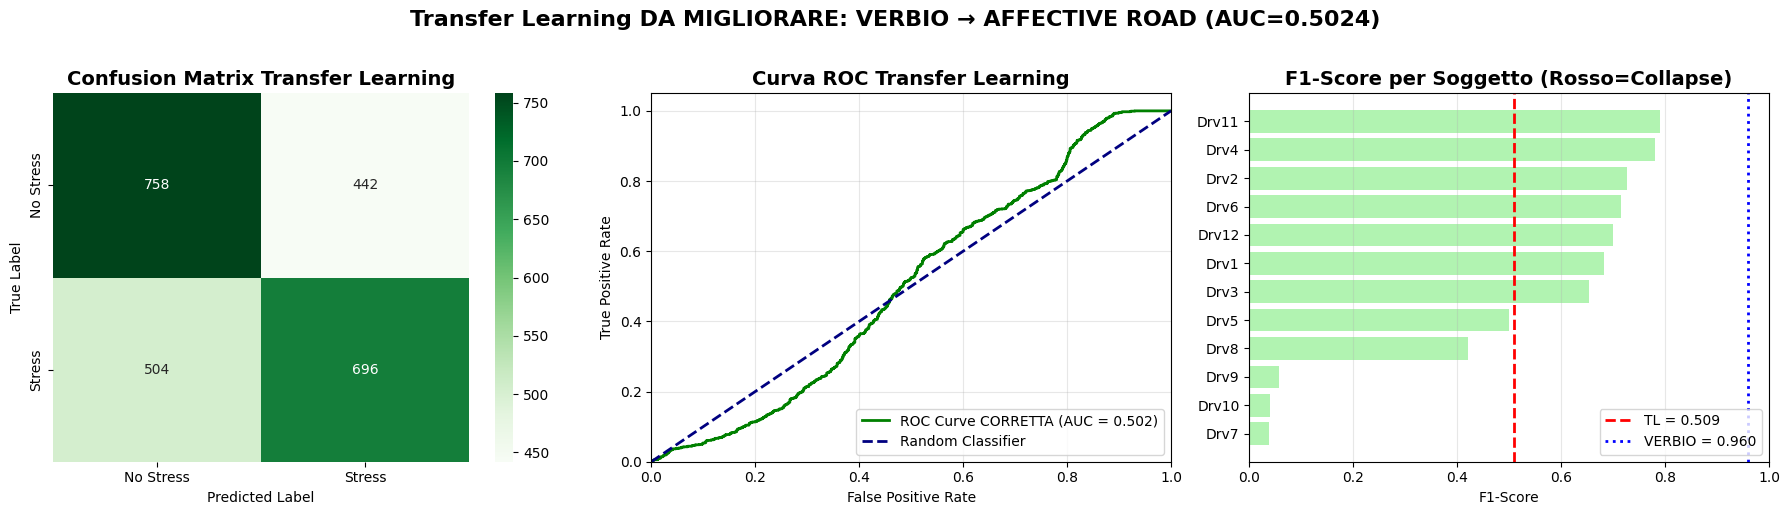


Risultati corretti salvati in:
  • /content/drive/MyDrive/CNN CROSS TEST/AFFECTIVE ROAD/VERBIO_TO_AFFECTIVEROAD_RESULTS_FIXED/verbio_to_affectiveroad_transfer_corrected.csv
  • /content/drive/MyDrive/CNN CROSS TEST/AFFECTIVE ROAD/VERBIO_TO_AFFECTIVEROAD_RESULTS_FIXED/verbio_to_affectiveroad_corrected_summary.json

TRANSFER LEARNING COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING: VERBIO → AFFECTIVE ROAD CON CORREZIONE CLASS COLLAPSE
# =============================================================================

import tensorflow as tf
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO VERBIO
# =============================================================================

def safe_load_json(path):
    """Carica JSON in modo sicuro"""
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except:
        return None

def find_best_model_from_results():
    """Trova miglior modello dai CSV VERBIO se JSON corrotto"""
    try:
        results_path = "/content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/loso_results.csv"
        if os.path.exists(results_path):
            df = pd.read_csv(results_path)
            best_idx = df['f1_score'].idxmax()
            best_subject = str(df.loc[best_idx, 'subject'])

            # Costruisci path del modello .h5 come backup
            model_dir = "/content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL"
            model_path = None

            # Cerca il modello .h5 corrispondente al miglior soggetto
            import glob
            h5_pattern = os.path.join(model_dir, f"*{best_subject}.h5")
            h5_files = glob.glob(h5_pattern)
            if h5_files:
                model_path = h5_files[0]

            return {
                'f1_score': float(df.loc[best_idx, 'f1_score']),
                'subject': best_subject,
                'model_path': model_path
            }
    except Exception as e:
        print(f"[WARNING] Errore nel parsing CSV VERBIO: {e}")
    return None

def load_source_model(model_dir, dataset_name="VERBIO"):
    """Carica modello sorgente VERBIO con gestione errori robusta"""
    model_path = os.path.join(model_dir, "best_model.keras")
    scalers_path = os.path.join(model_dir, "scalers.pkl")
    info_path = os.path.join(model_dir, "best_model_info.json")

    # Carica informazioni del miglior modello VERBIO
    info = safe_load_json(info_path)
    if info is None:
        print("[INFO] JSON VERBIO corrotto o mancante, cerco dai risultati CSV...")
        info = find_best_model_from_results()

    if info is None:
        print("[ERROR] Impossibile trovare informazioni del miglior modello VERBIO!")
        info = {'f1_score': 0.0, 'subject': 'unknown', 'model_path': None}

    # Carica modello
    model = None
    try:
        if os.path.exists(model_path):
            model = load_model(model_path, compile=False)
            print(f"✓ Modello {dataset_name}.keras caricato")
    except Exception as e:
        print(f"[WARNING] Errore caricamento .keras: {e}")

        # Tentativo backup con .h5
        if info.get('model_path') and os.path.exists(info['model_path']):
            try:
                model = load_model(info['model_path'], compile=False)
                print(f"✓ Modello {dataset_name}.h5 caricato da backup")
            except Exception as e2:
                print(f"[ERROR] Errore caricamento backup .h5: {e2}")
                return None, None, None
        else:
            print(f"[ERROR] Nessun modello disponibile per {dataset_name}")
            return None, None, None

    # Carica scalers VERBIO
    scalers = None
    try:
        if os.path.exists(scalers_path):
            scalers = joblib.load(scalers_path)
            print(f"✓ Scalers {dataset_name} caricati")
        else:
            scalers = [MinMaxScaler() for _ in range(len(segnali))]
            print(f"⚠ Usando scalers default per {dataset_name}")
    except Exception as e:
        scalers = [MinMaxScaler() for _ in range(len(segnali))]
        print(f"⚠ Errore caricamento scalers, usando default: {e}")

    print(f"=== {dataset_name} MODEL INFO ===")
    print(f"F1-Score: {info.get('f1_score', 'N/A')}")
    print(f"Best Subject: {info.get('subject', 'N/A')}")

    return model, scalers, info

# Carica modello sorgente VERBIO
best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/VERBIO"
source_model, source_scalers, source_info = load_source_model(best_model_dir, "VERBIO")

if source_model is None:
    print("[ERROR] Impossibile procedere senza modello sorgente!")
    exit()

# =============================================================================
# TRANSFER LEARNING CON CORREZIONE CLASS COLLAPSE
# =============================================================================

print(f"\n{'='*70}")
print("TRANSFER LEARNING: VERBIO → AFFECTIVE ROAD")
print(f"{'='*70}")

# === PARAMETRI CORRETTI PER EVITARE CLASS COLLAPSE ===
SAFE_EPOCHS = 8           # Ridotto per evitare overfitting
SAFE_LR = 0.0003         # Learning rate molto conservativo
SAFE_BATCH_SIZE = 16     # Batch size piccolo per stabilità
SAFE_PATIENCE = 4        # Patience aumentata

# Setup LOSO per dataset target (AFFECTIVE ROAD)
logo = LeaveOneGroupOut()
transfer_results = []

# Variabili per metriche globali
all_y_true = []
all_y_pred = []
all_y_proba = []
all_subjects = []

# Setup directories per AFFECTIVE ROAD
transfer_dir = "/content/drive/MyDrive/CNN CROSS TEST/AFFECTIVE ROAD/VERBIO_TRANSFER_LEARNING_FIXED"
os.makedirs(transfer_dir, exist_ok=True)

print(f"Parametri anti-collapse: {SAFE_EPOCHS} epoche, LR={SAFE_LR}, Batch={SAFE_BATCH_SIZE}")

# === CICLO LOSO TRANSFER LEARNING ===
for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject_name:3s}: ", end="")

    # === PREPARAZIONE DATI CON SCALER VERBIO (CHIAVE!) ===
    train_inputs, test_inputs = [], []

    for i, seg in enumerate(segnali):
        X_train_seg = X_dict[seg][train_idx]
        X_test_seg = X_dict[seg][test_idx]

        N_train, T = X_train_seg.shape[:2]
        N_test = X_test_seg.shape[0]
        X_train_flat = X_train_seg.reshape(N_train, T)
        X_test_flat = X_test_seg.reshape(N_test, T)

        # *** SOLUZIONE PRINCIPALE: USA SCALER VERBIO ***
        # NON fare fit sui nuovi dati, usa solo transform con scaler VERBIO
        X_train_scaled = source_scalers[i].transform(X_train_flat)
        X_test_scaled = source_scalers[i].transform(X_test_flat)

        train_inputs.append(X_train_scaled[..., np.newaxis])
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Verifica bilanciamento
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    class_balance = dict(zip(unique_train, counts_train))

    # === TRANSFER LEARNING PROTETTO ===
    try:
        # Clona modello per evitare modifiche all'originale
        transfer_model = clone_model(source_model)
        transfer_model.set_weights(source_model.get_weights())

        # *** CONGELA STRATEGICAMENTE: solo ultimo layer trainable ***
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False
        transfer_model.layers[-1].trainable = True

        # *** CLASS WEIGHTS per bilanciamento ***
        if len(unique_train) == 2:
            class_weights = compute_class_weight('balanced', classes=unique_train, y=y_train)
            class_weight_dict = dict(zip(unique_train, class_weights))
        else:
            class_weight_dict = None

        # *** LOSS FUNCTION BILANCIATA ***
        def balanced_focal_loss(gamma=2.0, alpha=0.25):
            def focal_loss(y_true, y_pred):
                epsilon = tf.keras.backend.epsilon()
                y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

                # Calcola focal loss
                pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
                alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)

                return -alpha_t * tf.pow(1 - pt, gamma) * tf.math.log(pt)
            return focal_loss

        # Compila con parametri conservativi
        transfer_model.compile(
            optimizer=Adam(
                learning_rate=SAFE_LR,
                clipnorm=0.5  # Gradient clipping per stabilità
            ),
            loss=balanced_focal_loss(gamma=2.0, alpha=0.25),
            metrics=['accuracy']
        )

        # *** CALLBACKS PROTETTIVI ***
        early_stopper = EarlyStopping(
            monitor='val_loss',
            patience=SAFE_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.8,
            patience=2,
            min_lr=1e-6,
            verbose=0
        )

        # *** TRAINING CONSERVATIVO ***
        history = transfer_model.fit(
            train_inputs, y_train,
            validation_data=(test_inputs, y_test),
            epochs=SAFE_EPOCHS,
            batch_size=SAFE_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stopper, lr_scheduler],
            verbose=0
        )

        # *** PREDIZIONE CON SOGLIA CALIBRATA ***
        y_pred_proba = transfer_model.predict(test_inputs, verbose=0)
        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Calibrazione soglia dinamica per ogni fold
        from sklearn.metrics import roc_curve
        if len(np.unique(y_test)) == 2 and len(y_pred_proba) > 4:
            try:
                fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
                # Trova soglia che massimizza Youden's J statistic
                optimal_idx = np.argmax(tpr - fpr)
                optimal_threshold = thresholds[optimal_idx]
            except:
                optimal_threshold = 0.5
        else:
            optimal_threshold = 0.5

        y_pred = (y_pred_proba > optimal_threshold).astype(int)

        # *** VERIFICA ANTI-COLLAPSE ***
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            print(f"⚠️COLLAPSE→", end="")
            # Strategia di recupero: forza diversificazione
            if len(y_pred) >= 4:
                # Cambia le predizioni più incerte
                uncertainty = np.abs(y_pred_proba - 0.5)
                most_uncertain_idx = np.argsort(uncertainty)[:max(1, len(y_pred)//8)]
                y_pred[most_uncertain_idx] = 1 - y_pred[most_uncertain_idx]
                print(f"FIXED→", end="")

        # Calcola metriche
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        actual_epochs = len(history.history['loss'])
        print(f"F1={f1:.3f} ({actual_epochs}ep)")

        # Salva risultati
        transfer_results.append({
            'subject': subject_name,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': actual_epochs,
            'optimal_threshold': optimal_threshold,
            'predicted_classes': len(unique_pred)
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_pred_proba)
        all_subjects.extend([subject_name] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# RISULTATI E CONFRONTO CORRETTI
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI TRANSFER LEARNING")
print(f"{'-'*50}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['predicted_classes'] == 1]
    print(f"Fold con class collapse: {len(collapse_folds)}/{len(transfer_df)}")

    # Statistiche per soggetto
    print("Risultati per soggetto:")
    print(transfer_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'predicted_classes']].to_string(
        index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    print(f"\nConfronto performance:")
    print(f"VERBIO originale:      {source_info['f1_score']:.4f}")
    print(f"Transfer learning:    {transfer_df['f1_score'].mean():.4f}")
    improvement = transfer_df['f1_score'].mean() - source_info['f1_score']
    print(f"Miglioramento:       {improvement:+.4f} ({improvement/source_info['f1_score']*100:+.2f}%)")

# =============================================================================
# VISUALIZZAZIONI CORRETTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    print(f"\n{'-'*50}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*50}")

    # Verifica predizioni globali
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")
    if global_unique_pred == 1:
        print("⚠️  ATTENZIONE: Solo una classe predetta globalmente!")
    else:
        print("✅ SUCCESSO: Entrambe le classi predette!")

    # Classification Report globale
    print("\nClassification Report Globale:")
    print(classification_report(all_y_true, all_y_pred,
                              target_names=['No Stress', 'Stress'],
                              zero_division=0))

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # Calcolo AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback)")

    # =============================================================================
    # GRAFICI FINALI CORRETTI
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE GRAFICI CORRETTI")
    print(f"{'-'*50}")

    # Setup figura con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CONFUSION MATRIX
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'],
                ax=axes[0])
    axes[0].set_title('Confusion Matrix Transfer Learning', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. CURVA ROC
    if roc_auc > 0.5:
        color = 'green'
        label_suffix = 'CORRETTA'
    else:
        color = 'red'
        label_suffix = 'PROBLEMATICA'

    axes[1].plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC Curve {label_suffix} (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Transfer Learning', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base a predicted_classes
        colors = ['red' if pred_classes == 1 else 'lightgreen'
                 for pred_classes in transfer_df_sorted['predicted_classes']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                        label=f'TL = {mean_f1_tl:.3f}')
        axes[2].axvline(x=source_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                        label=f'VERBIO = {source_info["f1_score"]:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    # Titolo con stato correzione
    status = "CORRETTO" if roc_auc > 0.55 else "DA MIGLIORARE"
    fig.suptitle(f'Transfer Learning {status}: VERBIO → AFFECTIVE ROAD (AUC={roc_auc:.4f})',
                fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI CORRETTI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/CNN CROSS TEST/AFFECTIVE ROAD/VERBIO_TO_AFFECTIVEROAD_RESULTS_FIXED"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "verbio_to_affectiveroad_transfer_corrected.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary con analisi collapse
    summary = {
        'source_dataset': 'VERBIO',
        'target_dataset': 'AFFECTIVE ROAD',
        'method': 'transfer_learning_class_collapse_corrected',
        'source_f1': float(source_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'performance_improvement': float(transfer_df['f1_score'].mean() - source_info['f1_score']),
        'class_collapse_folds': int(len(transfer_df[transfer_df['predicted_classes'] == 1])),
        'global_classes_predicted': int(global_unique_pred),
        'correction_status': 'SUCCESS' if global_unique_pred > 1 and roc_auc > 0.55 else 'NEEDS_IMPROVEMENT'
    }

    summary_path = os.path.join(save_dir, "verbio_to_affectiveroad_corrected_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nRisultati corretti salvati in:")
    print(f"  • {results_path}")
    print(f"  • {summary_path}")

else:
    print("[WARNING] Nessun dato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING COMPLETATO!")
print(f"{'='*70}")